In [20]:
import os
import time
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_sim_b1_e25_v0.pth'

16908615680
0
0


In [21]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [23]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
#         A.Resize(640, 480)  # Resize all images to be 640x480
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [24]:
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output  
    

In [25]:
class KPDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_file = self.imgs_files[idx]
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6')  

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original, img_file
        else:
            return img, target, img_file
    
    def __len__(self):
        return len(self.imgs_files)

In [26]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 7, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import networkx as nx


class GNNEncoder(nn.Module):
    def __init__(self, vertices_dim=5, hidden_dim=128, num_vertices=6):
        super(GNNEncoder, self).__init__()
        self.f_enc = nn.Linear(vertices_dim, hidden_dim)
        self.f_e1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.f_v = nn.Linear(hidden_dim, hidden_dim)
        self.f_e2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.num_vertices = num_vertices
        
    def generate_edges(self, vertices):
        vertices_list = vertices.tolist()
        G = nx.Graph()
        for idx, vertex in enumerate(vertices_list):
            G.add_node(idx, x=vertex[0], y=vertex[1], t=vertex[2], vis=vertex[3])  
            if idx < len(vertices_list) - 1:
                G.add_edge(idx, idx + 1)
        # Add the edge between the last and the first vertex to form a cycle
        G.add_edge(len(vertices_list) - 1, 0)
        edges = torch.tensor(list(G.edges), dtype=torch.long).to(vertices.device)
        return edges

#     def generate_edges(self, vertices):
#         vertices_list = vertices.tolist()
#         G = nx.Graph()
#         for idx, vertex in enumerate(vertices_list):
#             G.add_node(idx, x=vertex[0], y=vertex[1], t=vertex[2])  
#             if idx < len(vertices_list) - 1:
#                 G.add_edge(idx, idx + 1)
#         edges = torch.tensor(list(G.edges), dtype=torch.long).to(vertices.device)
#         return edges
    
#     def generate_edges(self, vertices):
#         num_vertices = vertices.shape[0]
#         all_edges = [[i, j] for i in range(num_vertices) for j in range(i+1, num_vertices)]
#         edges = torch.tensor(all_edges, dtype=torch.long).to(vertices.device)
#         return edges

    def forward(self, vertices):
        h1 = self.f_enc(vertices)
        edges = self.generate_edges(vertices)
#         print(edges)
        h1_source = h1[edges[:, 0]]
        h1_target = h1[edges[:, 1]]
        h_e1 = self.f_e1(torch.cat((h1_source, h1_target), dim=1))
        h_j_2 = self.f_v(h_e1)
        h2_source = h_j_2[edges[:, 0]]
        h2_target = h_j_2[edges[:, 1]]
        h_e2 = self.f_e2(torch.cat((h2_source, h2_target), dim=1))
        h_e2_prob = torch.sigmoid(h_e2)
        return vertices, h_e2_prob, edges

class GNNDecoder(nn.Module):
    def __init__(self, vertices_dim=5, hidden_dim=128, num_vertices=6):
        super(GNNDecoder, self).__init__()
        self.f_e = nn.Linear(vertices_dim * 2, hidden_dim)  # Concatenate two vertices features
        self.f_h = nn.Linear(hidden_dim, vertices_dim)  # Transform h_ij to the same dimension as vertices
        self.f_v = nn.Linear(vertices_dim, vertices_dim)  # Update vertex feature

    def forward(self, vertices, h_e2_prob, edges):
        h_source = vertices[edges[:, 0]]
        h_target = vertices[edges[:, 1]]
        h = torch.zeros_like(vertices)

        for idx, (i, j) in enumerate(edges):  # Iterate over edges
            h_ij = h_e2_prob[idx] * self.f_e(torch.cat((h_source[idx], h_target[idx]), dim=0))  # Apply edge function
            h_ij_transformed = self.f_h(h_ij)  # Transform h_ij to the same dimension as vertices
            h[j] += h_ij_transformed  # Accumulate edge features to the target vertex

        h_transformed = self.f_v(h.view(-1, vertices.shape[1]))  # Transform h
        h_transformed = h_transformed.view(vertices.shape)  # Reshape back to original shape
        vertices_g = vertices + h_transformed  # Update vertex features

        return vertices_g  # Return vertices_g as the prediction and vertices_g itself as the mean for Gaussian distribution



In [100]:
# class TrifocalLoss(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, vertices_pred, vertices_gt):
#         # Only consider the first two dimensions
#         vertices_pred = vertices_pred[:, :3]
#         vertices_gt = vertices_gt.squeeze()[:, :3]  # Use squeeze() to remove the singular dimension

#         loss = (vertices_gt - torch.tensor(vertices_pred)).pow(2).mean()  # Changed from sum() to mean()
#         return loss
# class HuberLoss(nn.Module):
#     def __init__(self, delta=1.0):
#         super().__init__()
#         self.delta = delta

#     def forward(self, vertices_pred, vertices_gt):
#         vertices_pred = vertices_pred[:, :3]
#         vertices_gt = vertices_gt.squeeze()[:, :3]
#         diff = (vertices_gt - vertices_pred).abs()
#         loss = torch.where(diff < self.delta, 0.5 * diff.pow(2), self.delta * (diff - 0.5 * self.delta))
#         return loss.mean()
# def cross_entropy_loss_func(edges_prob, edges_gt):
#     edges_gt_expanded = edges_gt.unsqueeze(-1).float()
#     loss_func = nn.BCEWithLogitsLoss()
#     loss = loss_func(edges_prob, edges_gt_expanded)
#     return loss
    
# class VisibleHuberLoss(nn.Module):
#     def __init__(self, delta=1.0):
#         super().__init__()
#         self.delta = delta

#     def forward(self, vertices_pred, vertices_gt):
#         print("Vertice_gt inside huber", vertices_gt)
#         visibility = vertices_gt[:, 3]  # extracting the visibility
#         vertices_pred = vertices_pred[:, :3]  # considering only x, y coordinates, confidence_score
#         vertices_gt = vertices_gt.squeeze()[:, :3]  # considering only x, y coordinates, confidence_score
#         print(f'vertices_pred shape: {vertices_pred.shape}')  # Debugging print
#         print(f'vertices_gt shape: {vertices_gt.shape}')  # Debugging print
#         diff = (vertices_gt - vertices_pred).abs()
#         loss = torch.where(diff < self.delta, 0.5 * diff.pow(2), self.delta * (diff - 0.5 * self.delta))
#         # Multiply by visibility
#         weighted_loss = visibility[:, None] * loss  # using None to keep dimensions consistent
#         return weighted_loss.mean()

class OccludedKeyPointLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, vertices_pred, vertices_gt):
        vertices_gt = vertices_gt.squeeze()
        print(vertices_gt.shape)
        visibility = vertices_gt[:, 3].unsqueeze(1)  # Extracting the visibility
#         visibility = visibility[:, :, :3]
        print(visibility)
        vertices_pred = vertices_pred[:, :3]  # Considering only x, y coordinates, confidence_score
        print(vertices_pred.shape)
        vertices_gt = vertices_gt[:, :3]  # Considering only x, y coordinates, confidence_score
        print(vertices_gt.shape)

        # Compute differences
        diff = (vertices_gt - vertices_pred).abs()

        # Huber loss for visible keypoints
        visible_loss = torch.where(visibility == 1.0, 
                                   torch.where(diff < self.delta, 0.5 * diff.pow(2), self.delta * (diff - 0.5 * self.delta)), 
                                   torch.tensor(0.0).to(vertices_pred.device))

        # For occluded keypoints, compute the distance to the nearest visible keypoint
        occluded_loss = torch.tensor(0.0).to(vertices_pred.device)
        if torch.any(visibility == 0.0):
            occluded_diff = vertices_pred[visibility == 0.0] - vertices_gt[visibility == 1.0][:, None]
            min_occluded_dist = occluded_diff.pow(2).sum(dim=-1).min(dim=0)[0].sqrt()
            occluded_loss = torch.where(diff < self.delta, 0.5 * min_occluded_dist.pow(2), self.delta * (min_occluded_dist - 0.5 * self.delta))

        # Total loss is the sum of the visible loss and the occluded loss
        loss = visible_loss.sum() + occluded_loss.sum()
        return loss

def edge_loss(edges_prob, edges_gt):
    # Expand edges_gt to match the shape of edges_prob
#     print(edges_prob.shape)
    edges_gt_expanded = torch.zeros(edges_prob.shape, dtype=torch.float32)
    
    for i in range(edges_gt.shape[0]):
        u, v = edges_gt[i]
#         print("u:", u)
#         print("v:", v)
#         print("edges_gt_expanded.shape:", edges_gt_expanded.shape)
        if i < edges_gt_expanded.shape[0]:
            if u < edges_gt_expanded.shape[1]:
                edges_gt_expanded[i, u] = 1
            if v < edges_gt_expanded.shape[1]:
                edges_gt_expanded[i, v] = 1
#         print('new u', u)
#         print('new v', v)
    # Compute the cross-entropy loss
    loss = -torch.sum(edges_gt_expanded.to(device) * torch.log(torch.clamp(edges_prob, min=1e-7)))
                      
    return loss



In [101]:
# class KeypointPipeline(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.keypoint_model = torch.load(weights_path).to(device)
#         self.keypoint_model.eval()  # Set the model to evaluation mode
#         self.keypoint_model = self.keypoint_model.to(device)
#         self.gnn_encoder = GNNEncoder()
#         self.gnn_decoder = GNNDecoder()
        
#     def forward(self, imgs):
#         outputs = []
#         for i in range(imgs.shape[0]):
#             img = imgs[i].unsqueeze(0).to(device)  # Unsqueeze the 0th dimension to make a batch of size 1
#             # Temporarily set the keypoint model to evaluation mode
#             keypoint_model_training = self.keypoint_model.training  # Save the current mode
#             self.keypoint_model.eval()
#             with torch.no_grad():
#                 output = self.keypoint_model(img)  # Keypoint model expects a list of images
                
#             # Set the keypoint model back to its previous mode
#             self.keypoint_model.train(keypoint_model_training)
                
#             img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
#             scores = output[0]['scores'].detach().cpu().numpy()
#             high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
#             post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], \
#                 output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

#             keypoints = []
#             key_points = []
#             for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#                 keypoints.append(list(map(int, kps[0,0:2])))
#                 key_points.append([list(map(int, kp[:2])) for kp in kps])

# #             print("keypoints", keypoints)

#             labels = []
#             for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#                 labels.append(label)
#     #             labels.append('j' + str(int(label)))
    
#             print("keypoints", keypoints)

# #             print("labels", labels)

# #             keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
#     #         kp_label = [list(x) + [y] for (x, y) in sorted(zip(keypoints, labels))]

#             # Create a dictionary where the key is the label and the value is the keypoint
#             label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}

#             # Convert the dictionary back to a list and sort it by the label keys
#             labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())] #,key=lambda item: int(item[0][1:]))]

# #             print("keypoints_", keypoints_)
#             print("kp_label", labeled_keypoints)
# # 
#             keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)
#             vertices, enc_e, edges = self.gnn_encoder(keypoints)
#             updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
#             outputs.append((updated_vertices, enc_e, edges))

#         return outputs  # A list of tuples, each containing updated_vertices, enc_e, edges for an image in the batch



In [102]:
class KeypointPipeline(nn.Module):
    def __init__(self, weights_path, num_vertices):
        super().__init__()

        self.keypoint_model = torch.load(weights_path).to(device)
        self.num_vertices = num_vertices
        self.gnn_encoder = GNNEncoder()
        self.gnn_decoder = GNNDecoder()

    def process_model_output(self, output):
        scores = output[0]['scores'].detach().cpu().numpy()
        high_scores_idxs = np.where(scores > 0.7)[0].tolist()

        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], 
                                            output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()

        confidence = output[0]['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
        labels = output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
        keypoints = []
        for idx, kps in enumerate(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
            # Setting t_i = 1 because label is found
            keypoints.append(list(map(int, kps[0,0:2])) + [confidence[idx]] + [1] + [labels[idx]])

        # Create a dictionary where the key is the label and the value is the keypoint
        label_to_keypoint = {}
        for idx, kps in enumerate(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
            # Setting t_i = 1 because label is found
            keypoints.append(list(map(int, kps[0,0:2])) + [confidence[idx]] + [1] + [labels[idx]])

        # Use a dictionary to keep track of all possible keypoints and their locations.
        # Initialize with placeholders for missing keypoints.
        all_keypoints = {i: [-1, -1, 0, 0, i] for i in range(1, self.num_vertices+1)}  # added another 0 for t_i

        for keypoint in keypoints:
            label = keypoint[-1]
            if label not in label_to_keypoint or label_to_keypoint[label][-2] < keypoint[-2]:
                all_keypoints[label] = keypoint

        # Convert the dictionary values back into a list
        keypoints = list(all_keypoints.values())
        return keypoints

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))

#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)

#         label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}
#         labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())]

        return keypoints

    def process_image(self, img):
        img = img.unsqueeze(0).to(device)
        # Temporarily set the keypoint model to evaluation mode
        keypoint_model_training = self.keypoint_model.training  # Save the current mode
        self.keypoint_model.eval()
        with torch.no_grad():
            output = self.keypoint_model(img)
        # Set the keypoint model back to its previous mode
        self.keypoint_model.train(keypoint_model_training)
        img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        labeled_keypoints = self.process_model_output(output)

        return labeled_keypoints

    def forward(self, imgs):
        outputs = []

        for i in range(imgs.shape[0]):
            labeled_keypoints = self.process_image(imgs[i])
            keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)

            vertices, enc_e, edges = self.gnn_encoder(keypoints)
            updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
            outputs.append((updated_vertices, enc_e, edges))

        return outputs
    

In [103]:
# class KeypointPipeline(nn.Module):
#     def __init__(self, num_keypoints, weights_path=None):
#         super().__init__()

#         # Instantiate your Keypoint R-CNN model
#         self.keypoint_model = get_model(num_keypoints, weights_path)
#         self.keypoint_model.to(device)

#         self.gnn_encoder = GNNEncoder()
#         self.gnn_decoder = GNNDecoder()

#     def process_model_output(self, output):
#         scores = output[0]['scores'].detach().cpu().numpy()
#         high_scores_idxs = np.where(scores > 0.7)[0].tolist()

#         post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], 
#                                             output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))

#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)

#         label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}
#         labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())]

#         return labeled_keypoints

#     def process_image(self, img):
#         img = img.unsqueeze(0).to(device)
#         # Temporarily set the keypoint model to evaluation mode
#         keypoint_model_training = self.keypoint_model.training  # Save the current mode
#         self.keypoint_model.eval()
#         with torch.no_grad():
#             output = self.keypoint_model(img)
#         print("Output", output)
#         # Set the keypoint model back to its previous mode
#         self.keypoint_model.train(keypoint_model_training)
#         img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
#         labeled_keypoints = self.process_model_output(output)

#         return labeled_keypoints

#     def forward(self, imgs):
#         outputs = []

#         for i in range(imgs.shape[0]):
#             labeled_keypoints = self.process_image(imgs[i])
#             keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)

#             vertices, enc_e, edges = self.gnn_encoder(keypoints)
#             updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
#             outputs.append((updated_vertices, enc_e, edges))

#         return outputs

In [105]:
# Define the model
model = KeypointPipeline(weights_path, num_vertices=6)
model = model.to(device)

# Define the loss
criterion = OccludedKeyPointLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30  # Define your number of epochs
batch_size = 4

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = KPDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_val = KPDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = KPDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)
v = 2
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    for i, batch in enumerate(data_loader_train):
        img_tuple, target_dict_tuple, img_files = batch
        print(f"Processing batch {i+1} with images:", img_files)
        
        imgs = [img.to(device) for img in img_tuple]  # Create list of images

        # Process each image individually
        losses = []
        for i in range(len(imgs)):
            img = imgs[i].unsqueeze(0)  # Unsqueeze to add batch dimension

            # Prepare ground truth vertices for the image
            keypoints = target_dict_tuple[i]['keypoints'].to(device)
            visibility = torch.ones((keypoints.shape[0], keypoints.shape[1], 1)).to(device)
            vertices_gt = torch.cat((keypoints, visibility), dim=2).unsqueeze(0)  # Unsqueeze to add batch dimension

            # Forward pass
            output = model(img)
            vertices_pred, edges_prob, edges_gt = output[0]

            # Compute loss for the image
            huber_loss = criterion(vertices_pred, vertices_gt)
            ce_loss = edge_loss(edges_prob, edges_gt)

            loss = huber_loss + ce_loss
            losses.append(loss)  # Store loss for the image

        # Average loss over all images in the batch
        loss = torch.mean(torch.stack(losses))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    end_time = time.time()
    epoch_time = end_time - start_time
    eta = epoch_time * (num_epochs - epoch - 1)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, ETA: {eta} seconds')

model_save_path = f"/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_occ_b{batch_size}_e{num_epochs}_v{v}.pth"

torch.save(model, model_save_path)
    
# Save the state dict of the model, not the entire model
# torch.save(model.state_dict(), model_save_path)
    
torch.save(model, model_save_path)


# model.train()
# # Epoch loop
# for epoch in range(num_epochs):
#     # For each batch in your training data
#     for batch in data_loader_train:
#         img_tuple, target_dict_tuple = batch
#         img = img_tuple[0]
# #         print(img.shape)
#         target = target_dict_tuple[0]
#         img = img.to(device)
#         vertices_gt = target['keypoints'].to(device)
#         num_vertices = vertices_gt.shape[0]
#         print(num_vertices)
#         vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

#         # Forward pass
#         vertices_pred, edges_prob, edges_gt = model(img)
        
#         # Compute the losses
#         trifocal_loss = criterion(vertices_pred, vertices_gt)
#         ce_loss = edge_loss(edges_prob, edges_gt)

#         # Combined loss
#         loss = trifocal_loss + ce_loss
# #         loss = trifocal_loss

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
        
#         optimizer.step()

#     # Print loss for each epoch
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Copying files: 2662 files [00:00, 17243.16 files/s]
Copying files: 2662 files [00:00, 17819.87 files/s]
Copying files: 2662 files [00:00, 18338.72 files/s]


Processing batch 1 with images: ('000212.rgb.jpg', '000329.rgb.jpg', '000990.rgb.jpg', '000394.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 2 with images: ('000347.rgb.jpg', '000072.rgb.jpg', '000914.rgb.jpg', '001023.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6,

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 13 with images: ('001138.rgb.jpg', '000232.rgb.jpg', '001012.rgb.jpg', '001049.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 24 with images: ('000086.rgb.jpg', '000579.rgb.jpg', '001227.rgb.jpg', '000800.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 25 with images: ('001031.rgb.jpg', '000391.rgb.jpg', '001053.rgb.jpg', '000258.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 36 with images: ('001085.rgb.jpg', '000300.rgb.jpg', '001250.rgb.jpg', '000415.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 47 with images: ('001170.rgb.jpg', '000848.rgb.jpg', '000266.rgb.jpg', '000620.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 58 with images: ('000295.rgb.jpg', '000230.rgb.jpg', '000822.rgb.jpg', '000639.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 69 with images: ('000650.rgb.jpg', '000149.rgb.jpg', '000557.rgb.jpg', '000403.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 70 with images: ('000219.rgb.jpg', '000336.rgb.jpg', '000020.rgb.jpg', '000372.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 81 with images: ('001147.rgb.jpg', '001225.rgb.jpg', '000293.rgb.jpg', '000896.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 92 with images: ('001315.rgb.jpg', '000123.rgb.jpg', '000331.rgb.jpg', '000398.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 103 with images: ('000804.rgb.jpg', '000523.rgb.jpg', '000021.rgb.jpg', '000431.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 114 with images: ('000491.rgb.jpg', '000575.rgb.jpg', '000730.rgb.jpg', '000195.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 115 with images: ('000251.rgb.jpg', '000083.rgb.jpg', '000370.rgb.jpg', '001202.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 126 with images: ('000439.rgb.jpg', '000791.rgb.jpg', '000860.rgb.jpg', '001056.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 137 with images: ('000048.rgb.jpg', '001201.rgb.jpg', '001091.rgb.jpg', '000254.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 148 with images: ('001218.rgb.jpg', '000934.rgb.jpg', '000666.rgb.jpg', '000944.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 159 with images: ('001215.rgb.jpg', '000098.rgb.jpg', '001212.rgb.jpg', '000357.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 160 with images: ('000675.rgb.jpg', '001223.rgb.jpg', '000988.rgb.jpg', '000769.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 171 with images: ('000839.rgb.jpg', '000793.rgb.jpg', '000343.rgb.jpg', '000143.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 182 with images: ('000272.rgb.jpg', '000473.rgb.jpg', '001271.rgb.jpg', '001115.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 193 with images: ('001196.rgb.jpg', '000227.rgb.jpg', '000089.rgb.jpg', '000308.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 204 with images: ('001017.rgb.jpg', '000726.rgb.jpg', '000891.rgb.jpg', '000519.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 205 with images: ('000586.rgb.jpg', '000818.rgb.jpg', '001065.rgb.jpg', '000049.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 216 with images: ('001002.rgb.jpg', '000055.rgb.jpg', '001311.rgb.jpg', '000971.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 227 with images: ('000456.rgb.jpg', '000729.rgb.jpg', '000386.rgb.jpg', '001199.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 6 with images: ('000297.rgb.jpg', '001020.rgb.jpg', '000002.rgb.jpg', '000252.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 17 with images: ('000744.rgb.jpg', '000686.rgb.jpg', '001096.rgb.jpg', '000056.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 28 with images: ('000219.rgb.jpg', '001077.rgb.jpg', '000295.rgb.jpg', '001175.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 29 with images: ('001273.rgb.jpg', '000868.rgb.jpg', '000031.rgb.jpg', '000047.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 40 with images: ('000794.rgb.jpg', '000244.rgb.jpg', '001158.rgb.jpg', '000577.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 51 with images: ('001283.rgb.jpg', '000708.rgb.jpg', '001166.rgb.jpg', '000684.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 62 with images: ('001280.rgb.jpg', '000555.rgb.jpg', '000494.rgb.jpg', '000879.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 63 with images: ('000241.rgb.jpg', '000851.rgb.jpg', '001088.rgb.jpg', '000830.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 74 with images: ('001302.rgb.jpg', '000123.rgb.jpg', '000656.rgb.jpg', '000479.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 85 with images: ('000745.rgb.jpg', '000792.rgb.jpg', '000770.rgb.jpg', '000277.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 86 with images: ('001157.rgb.jpg', '000390.rgb.jpg', '001111.rgb.jpg', '000537.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 97 with images: ('001069.rgb.jpg', '001002.rgb.jpg', '000763.rgb.jpg', '000328.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 108 with images: ('000308.rgb.jpg', '000978.rgb.jpg', '000190.rgb.jpg', '000616.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 109 with images: ('001321.rgb.jpg', '000885.rgb.jpg', '001011.rgb.jpg', '000887.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 120 with images: ('000382.rgb.jpg', '000796.rgb.jpg', '000472.rgb.jpg', '001177.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 131 with images: ('001315.rgb.jpg', '000320.rgb.jpg', '001117.rgb.jpg', '000404.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 142 with images: ('000986.rgb.jpg', '000894.rgb.jpg', '000625.rgb.jpg', '000035.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 153 with images: ('001279.rgb.jpg', '000532.rgb.jpg', '000086.rgb.jpg', '000055.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 154 with images: ('000964.rgb.jpg', '000439.rgb.jpg', '001204.rgb.jpg', '000282.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 165 with images: ('001262.rgb.jpg', '000942.rgb.jpg', '000352.rgb.jpg', '001109.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 176 with images: ('001055.rgb.jpg', '001056.rgb.jpg', '000580.rgb.jpg', '000304.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 187 with images: ('001200.rgb.jpg', '000677.rgb.jpg', '000843.rgb.jpg', '000670.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 198 with images: ('000413.rgb.jpg', '001254.rgb.jpg', '000900.rgb.jpg', '001240.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 199 with images: ('000007.rgb.jpg', '000129.rgb.jpg', '000804.rgb.jpg', '000183.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 210 with images: ('001027.rgb.jpg', '000391.rgb.jpg', '000535.rgb.jpg', '000752.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 221 with images: ('001218.rgb.jpg', '001137.rgb.jpg', '000480.rgb.jpg', '001317.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 232 with images: ('000540.rgb.jpg', '000284.rgb.jpg', '001169.rgb.jpg', '000640.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 11 with images: ('001286.rgb.jpg', '000253.rgb.jpg', '001278.rgb.jpg', '000757.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 22 with images: ('000856.rgb.jpg', '001030.rgb.jpg', '000736.rgb.jpg', '000870.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 33 with images: ('000421.rgb.jpg', '000479.rgb.jpg', '000099.rgb.jpg', '001023.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 44 with images: ('000401.rgb.jpg', '000843.rgb.jpg', '000623.rgb.jpg', '000834.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 45 with images: ('001169.rgb.jpg', '000990.rgb.jpg', '001200.rgb.jpg', '001115.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 56 with images: ('000263.rgb.jpg', '000482.rgb.jpg', '000300.rgb.jpg', '000428.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 67 with images: ('000944.rgb.jpg', '001153.rgb.jpg', '000807.rgb.jpg', '001196.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 78 with images: ('001144.rgb.jpg', '001002.rgb.jpg', '000000.rgb.jpg', '000605.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 89 with images: ('000840.rgb.jpg', '001180.rgb.jpg', '000691.rgb.jpg', '000861.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 90 with images: ('000016.rgb.jpg', '000786.rgb.jpg', '000070.rgb.jpg', '000056.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 101 with images: ('001124.rgb.jpg', '000713.rgb.jpg', '000194.rgb.jpg', '000071.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 112 with images: ('000456.rgb.jpg', '000182.rgb.jpg', '000962.rgb.jpg', '000550.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 123 with images: ('000603.rgb.jpg', '000868.rgb.jpg', '001273.rgb.jpg', '001302.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 134 with images: ('000978.rgb.jpg', '000705.rgb.jpg', '001164.rgb.jpg', '000420.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 135 with images: ('001262.rgb.jpg', '000986.rgb.jpg', '001257.rgb.jpg', '000369.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 146 with images: ('000413.rgb.jpg', '000362.rgb.jpg', '000568.rgb.jpg', '000265.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 157 with images: ('000180.rgb.jpg', '001260.rgb.jpg', '000293.rgb.jpg', '000381.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 168 with images: ('000609.rgb.jpg', '000295.rgb.jpg', '001109.rgb.jpg', '000080.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 179 with images: ('000297.rgb.jpg', '000915.rgb.jpg', '000026.rgb.jpg', '001162.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 180 with images: ('000121.rgb.jpg', '001105.rgb.jpg', '000473.rgb.jpg', '001033.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 191 with images: ('000660.rgb.jpg', '000279.rgb.jpg', '000800.rgb.jpg', '000305.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 202 with images: ('000582.rgb.jpg', '001315.rgb.jpg', '000169.rgb.jpg', '001061.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 213 with images: ('001065.rgb.jpg', '001158.rgb.jpg', '000086.rgb.jpg', '000188.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 224 with images: ('000382.rgb.jpg', '000979.rgb.jpg', '000250.rgb.jpg', '001321.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 225 with images: ('000848.rgb.jpg', '001111.rgb.jpg', '000089.rgb.jpg', '000226.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 3 with images: ('001035.rgb.jpg', '000855.rgb.jpg', '000831.rgb.jpg', '000095.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 14 with images: ('000406.rgb.jpg', '000236.rgb.jpg', '000396.rgb.jpg', '000908.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 25 with images: ('000060.rgb.jpg', '000791.rgb.jpg', '000590.rgb.jpg', '000055.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 26 with images: ('001193.rgb.jpg', '000729.rgb.jpg', '001215.rgb.jpg', '001229.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 37 with images: ('000284.rgb.jpg', '001256.rgb.jpg', '000480.rgb.jpg', '001174.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 48 with images: ('001019.rgb.jpg', '000293.rgb.jpg', '001180.rgb.jpg', '001129.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 59 with images: ('000128.rgb.jpg', '000802.rgb.jpg', '000381.rgb.jpg', '000099.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 71 with images: ('000576.rgb.jpg', '000331.rgb.jpg', '001185.rgb.jpg', '000650.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 82 with images: ('000053.rgb.jpg', '000804.rgb.jpg', '000823.rgb.jpg', '000835.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 93 with images: ('000816.rgb.jpg', '000695.rgb.jpg', '001092.rgb.jpg', '001233.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 94 with images: ('001169.rgb.jpg', '000347.rgb.jpg', '000779.rgb.jpg', '000530.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 105 with images: ('000115.rgb.jpg', '000427.rgb.jpg', '000512.rgb.jpg', '000079.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 116 with images: ('000969.rgb.jpg', '000989.rgb.jpg', '000032.rgb.jpg', '000894.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 127 with images: ('000335.rgb.jpg', '000187.rgb.jpg', '000754.rgb.jpg', '000105.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 138 with images: ('000594.rgb.jpg', '001152.rgb.jpg', '000363.rgb.jpg', '000308.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 139 with images: ('000360.rgb.jpg', '000912.rgb.jpg', '000618.rgb.jpg', '000656.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 150 with images: ('000767.rgb.jpg', '000275.rgb.jpg', '000276.rgb.jpg', '000930.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 161 with images: ('000029.rgb.jpg', '000237.rgb.jpg', '001070.rgb.jpg', '001095.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 162 with images: ('000503.rgb.jpg', '000000.rgb.jpg', '000952.rgb.jpg', '000233.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 173 with images: ('000917.rgb.jpg', '001201.rgb.jpg', '000402.rgb.jpg', '000253.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 184 with images: ('000377.rgb.jpg', '001214.rgb.jpg', '000011.rgb.jpg', '001111.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 195 with images: ('000790.rgb.jpg', '001097.rgb.jpg', '000368.rgb.jpg', '001302.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 206 with images: ('000739.rgb.jpg', '000325.rgb.jpg', '000834.rgb.jpg', '001177.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 207 with images: ('000426.rgb.jpg', '001033.rgb.jpg', '000891.rgb.jpg', '000780.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 218 with images: ('000414.rgb.jpg', '000828.rgb.jpg', '000845.rgb.jpg', '000667.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 229 with images: ('000829.rgb.jpg', '000839.rgb.jpg', '000671.rgb.jpg', '000662.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 7 with images: ('001157.rgb.jpg', '000804.rgb.jpg', '001244.rgb.jpg', '000952.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 8 with images: ('000232.rgb.jpg', '001227.rgb.jpg', '000755.rgb.jpg', '000678.rgb.j

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 19 with images: ('000633.rgb.jpg', '000099.rgb.jpg', '001250.rgb.jpg', '001165.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 30 with images: ('000162.rgb.jpg', '000856.rgb.jpg', '001264.rgb.jpg', '000893.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 41 with images: ('000752.rgb.jpg', '001005.rgb.jpg', '001190.rgb.jpg', '000305.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 52 with images: ('000598.rgb.jpg', '000774.rgb.jpg', '000115.rgb.jpg', '000716.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 53 with images: ('000966.rgb.jpg', '000506.rgb.jpg', '000748.rgb.jpg', '001016.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 64 with images: ('000489.rgb.jpg', '000144.rgb.jpg', '000993.rgb.jpg', '001201.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 75 with images: ('001100.rgb.jpg', '000424.rgb.jpg', '000744.rgb.jpg', '000364.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 86 with images: ('000371.rgb.jpg', '000593.rgb.jpg', '000823.rgb.jpg', '000097.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 97 with images: ('000031.rgb.jpg', '001193.rgb.jpg', '000125.rgb.jpg', '000339.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 98 with images: ('000496.rgb.jpg', '001288.rgb.jpg', '000745.rgb.jpg', '000069.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 109 with images: ('000187.rgb.jpg', '000027.rgb.jpg', '000007.rgb.jpg', '000075.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 120 with images: ('001050.rgb.jpg', '000346.rgb.jpg', '000372.rgb.jpg', '000416.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 131 with images: ('000401.rgb.jpg', '000785.rgb.jpg', '000261.rgb.jpg', '001252.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 142 with images: ('000575.rgb.jpg', '000128.rgb.jpg', '001233.rgb.jpg', '000773.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 143 with images: ('000811.rgb.jpg', '000000.rgb.jpg', '000472.rgb.jpg', '000280.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 154 with images: ('001089.rgb.jpg', '001293.rgb.jpg', '000483.rgb.jpg', '001289.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 165 with images: ('000965.rgb.jpg', '000687.rgb.jpg', '000396.rgb.jpg', '000586.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 176 with images: ('000033.rgb.jpg', '000713.rgb.jpg', '000456.rgb.jpg', '001272.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 187 with images: ('000717.rgb.jpg', '000157.rgb.jpg', '000053.rgb.jpg', '000852.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 188 with images: ('000787.rgb.jpg', '000226.rgb.jpg', '000290.rgb.jpg', '000307.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 199 with images: ('000213.rgb.jpg', '000972.rgb.jpg', '001021.rgb.jpg', '000790.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 210 with images: ('000843.rgb.jpg', '000358.rgb.jpg', '001067.rgb.jpg', '001235.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 221 with images: ('000948.rgb.jpg', '001224.rgb.jpg', '001220.rgb.jpg', '000105.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 232 with images: ('000238.rgb.jpg', '001001.rgb.jpg', '000532.rgb.jpg', '000044.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 233 with images: ('000654.rgb.jpg', '001304.rgb.jpg', '001009.rgb.jpg')
torch.Siz

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 11 with images: ('000602.rgb.jpg', '000816.rgb.jpg', '001199.rgb.jpg', '001115.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 22 with images: ('000339.rgb.jpg', '000724.rgb.jpg', '000717.rgb.jpg', '000079.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 33 with images: ('000502.rgb.jpg', '001215.rgb.jpg', '000632.rgb.jpg', '001021.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 34 with images: ('001260.rgb.jpg', '000275.rgb.jpg', '000328.rgb.jpg', '001061.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 45 with images: ('001183.rgb.jpg', '001033.rgb.jpg', '000160.rgb.jpg', '000180.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 56 with images: ('000839.rgb.jpg', '000002.rgb.jpg', '000625.rgb.jpg', '000227.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 67 with images: ('000616.rgb.jpg', '000062.rgb.jpg', '001144.rgb.jpg', '001228.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 78 with images: ('000087.rgb.jpg', '001173.rgb.jpg', '000168.rgb.jpg', '001014.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 79 with images: ('001262.rgb.jpg', '000205.rgb.jpg', '000761.rgb.jpg', '000308.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 90 with images: ('001053.rgb.jpg', '000823.rgb.jpg', '001285.rgb.jpg', '000960.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 101 with images: ('000394.rgb.jpg', '001249.rgb.jpg', '000884.rgb.jpg', '000639.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 112 with images: ('000809.rgb.jpg', '000456.rgb.jpg', '000684.rgb.jpg', '000551.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 123 with images: ('000056.rgb.jpg', '000819.rgb.jpg', '000702.rgb.jpg', '000794.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 124 with images: ('001180.rgb.jpg', '000343.rgb.jpg', '000880.rgb.jpg', '000115.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 135 with images: ('001124.rgb.jpg', '001243.rgb.jpg', '000583.rgb.jpg', '001288.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 146 with images: ('000258.rgb.jpg', '000031.rgb.jpg', '000021.rgb.jpg', '001003.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 157 with images: ('000405.rgb.jpg', '000723.rgb.jpg', '000797.rgb.jpg', '000964.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 168 with images: ('000537.rgb.jpg', '000280.rgb.jpg', '000609.rgb.jpg', '000408.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 169 with images: ('000526.rgb.jpg', '000636.rgb.jpg', '000125.rgb.jpg', '001280.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 180 with images: ('000450.rgb.jpg', '001250.rgb.jpg', '000674.rgb.jpg', '000430.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 191 with images: ('000966.rgb.jpg', '000787.rgb.jpg', '000455.rgb.jpg', '001044.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 202 with images: ('000276.rgb.jpg', '000762.rgb.jpg', '000885.rgb.jpg', '000837.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 213 with images: ('000098.rgb.jpg', '001200.rgb.jpg', '000571.rgb.jpg', '000965.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 214 with images: ('000171.rgb.jpg', '000660.rgb.jpg', '000286.rgb.jpg', '000123.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 225 with images: ('000329.rgb.jpg', '000092.rgb.jpg', '000342.rgb.jpg', '000090.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 3 with images: ('001008.rgb.jpg', '000610.rgb.jpg', '000216.rgb.jpg', '000702.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 14 with images: ('000048.rgb.jpg', '000755.rgb.jpg', '001004.rgb.jpg', '001244.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 15 with images: ('000624.rgb.jpg', '000738.rgb.jpg', '001162.rgb.jpg', '000660.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 26 with images: ('001100.rgb.jpg', '000122.rgb.jpg', '000532.rgb.jpg', '000352.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 37 with images: ('000905.rgb.jpg', '001184.rgb.jpg', '000984.rgb.jpg', '000739.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 48 with images: ('000828.rgb.jpg', '000391.rgb.jpg', '000838.rgb.jpg', '000869.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 59 with images: ('000608.rgb.jpg', '000254.rgb.jpg', '000362.rgb.jpg', '000823.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 60 with images: ('000609.rgb.jpg', '000281.rgb.jpg', '000499.rgb.jpg', '000577.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 71 with images: ('001212.rgb.jpg', '001114.rgb.jpg', '000211.rgb.jpg', '001128.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 82 with images: ('000168.rgb.jpg', '000645.rgb.jpg', '001170.rgb.jpg', '000414.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 93 with images: ('000299.rgb.jpg', '001279.rgb.jpg', '000401.rgb.jpg', '000101.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 104 with images: ('001321.rgb.jpg', '000294.rgb.jpg', '000112.rgb.jpg', '001260.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 105 with images: ('000801.rgb.jpg', '001175.rgb.jpg', '000721.rgb.jpg', '001261.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 116 with images: ('001032.rgb.jpg', '000158.rgb.jpg', '000308.rgb.jpg', '000455.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 127 with images: ('000383.rgb.jpg', '000524.rgb.jpg', '000467.rgb.jpg', '000537.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 138 with images: ('001301.rgb.jpg', '001263.rgb.jpg', '001142.rgb.jpg', '000080.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 149 with images: ('001019.rgb.jpg', '000300.rgb.jpg', '001257.rgb.jpg', '000243.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 150 with images: ('000057.rgb.jpg', '000784.rgb.jpg', '000166.rgb.jpg', '000992.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 161 with images: ('000082.rgb.jpg', '000742.rgb.jpg', '000067.rgb.jpg', '000305.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 172 with images: ('000329.rgb.jpg', '000250.rgb.jpg', '001121.rgb.jpg', '001325.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 183 with images: ('000477.rgb.jpg', '000474.rgb.jpg', '000443.rgb.jpg', '000304.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 194 with images: ('000690.rgb.jpg', '000293.rgb.jpg', '000785.rgb.jpg', '000573.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 195 with images: ('001065.rgb.jpg', '001011.rgb.jpg', '000783.rgb.jpg', '001188.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 206 with images: ('000557.rgb.jpg', '000252.rgb.jpg', '000529.rgb.jpg', '000966.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 217 with images: ('000787.rgb.jpg', '000661.rgb.jpg', '000279.rgb.jpg', '000230.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 228 with images: ('000622.rgb.jpg', '000458.rgb.jpg', '000752.rgb.jpg', '000653.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 7 with images: ('001312.rgb.jpg', '001183.rgb.jpg', '001301.rgb.jpg', '000406.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 18 with images: ('000156.rgb.jpg', '000547.rgb.jpg', '001233.rgb.jpg', '001120.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 29 with images: ('000903.rgb.jpg', '000589.rgb.jpg', '001085.rgb.jpg', '000249.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 40 with images: ('000986.rgb.jpg', '000126.rgb.jpg', '000885.rgb.jpg', '000856.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 41 with images: ('000610.rgb.jpg', '000716.rgb.jpg', '001187.rgb.jpg', '000485.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 52 with images: ('000978.rgb.jpg', '000668.rgb.jpg', '000227.rgb.jpg', '000805.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 63 with images: ('000732.rgb.jpg', '000214.rgb.jpg', '000018.rgb.jpg', '000937.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 74 with images: ('000525.rgb.jpg', '001009.rgb.jpg', '000581.rgb.jpg', '000972.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 85 with images: ('000007.rgb.jpg', '001265.rgb.jpg', '000475.rgb.jpg', '000169.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 86 with images: ('000651.rgb.jpg', '000806.rgb.jpg', '000818.rgb.jpg', '000385.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 97 with images: ('001079.rgb.jpg', '000846.rgb.jpg', '001207.rgb.jpg', '000796.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 108 with images: ('000153.rgb.jpg', '000381.rgb.jpg', '000712.rgb.jpg', '001091.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 119 with images: ('001111.rgb.jpg', '001216.rgb.jpg', '000684.rgb.jpg', '000944.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 130 with images: ('001049.rgb.jpg', '000035.rgb.jpg', '000900.rgb.jpg', '000942.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 131 with images: ('001095.rgb.jpg', '000464.rgb.jpg', '000835.rgb.jpg', '000773.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 142 with images: ('001260.rgb.jpg', '000951.rgb.jpg', '000620.rgb.jpg', '001147.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 153 with images: ('001175.rgb.jpg', '000121.rgb.jpg', '000428.rgb.jpg', '000308.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 164 with images: ('000456.rgb.jpg', '000372.rgb.jpg', '001077.rgb.jpg', '000793.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 175 with images: ('001282.rgb.jpg', '000555.rgb.jpg', '000813.rgb.jpg', '000608.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 176 with images: ('001327.rgb.jpg', '000752.rgb.jpg', '000842.rgb.jpg', '001304.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 187 with images: ('000463.rgb.jpg', '000771.rgb.jpg', '000482.rgb.jpg', '000321.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 198 with images: ('000746.rgb.jpg', '000282.rgb.jpg', '001092.rgb.jpg', '001014.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 209 with images: ('000751.rgb.jpg', '001112.rgb.jpg', '000489.rgb.jpg', '001056.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 220 with images: ('000528.rgb.jpg', '000506.rgb.jpg', '000101.rgb.jpg', '000678.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 221 with images: ('001005.rgb.jpg', '000033.rgb.jpg', '000038.rgb.jpg', '000656.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 232 with images: ('001152.rgb.jpg', '001191.rgb.jpg', '000790.rgb.jpg', '000273.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 10 with images: ('000062.rgb.jpg', '000667.rgb.jpg', '001258.rgb.jpg', '000603.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 21 with images: ('000434.rgb.jpg', '000134.rgb.jpg', '000486.rgb.jpg', '000067.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 22 with images: ('000057.rgb.jpg', '000862.rgb.jpg', '000855.rgb.jpg', '000804.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 33 with images: ('000428.rgb.jpg', '000656.rgb.jpg', '000528.rgb.jpg', '000510.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 44 with images: ('000944.rgb.jpg', '000029.rgb.jpg', '000361.rgb.jpg', '001260.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 55 with images: ('001308.rgb.jpg', '000355.rgb.jpg', '000213.rgb.jpg', '000895.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 66 with images: ('000417.rgb.jpg', '000098.rgb.jpg', '000917.rgb.jpg', '000655.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 67 with images: ('000889.rgb.jpg', '001111.rgb.jpg', '001145.rgb.jpg', '000977.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 78 with images: ('000017.rgb.jpg', '000015.rgb.jpg', '000693.rgb.jpg', '000028.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 89 with images: ('001031.rgb.jpg', '000513.rgb.jpg', '000059.rgb.jpg', '000166.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 100 with images: ('000916.rgb.jpg', '000883.rgb.jpg', '000675.rgb.jpg', '001100.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 111 with images: ('000214.rgb.jpg', '001185.rgb.jpg', '000205.rgb.jpg', '000233.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 112 with images: ('000803.rgb.jpg', '001018.rgb.jpg', '000236.rgb.jpg', '000633.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 123 with images: ('000453.rgb.jpg', '001251.rgb.jpg', '000423.rgb.jpg', '000912.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 134 with images: ('000878.rgb.jpg', '000421.rgb.jpg', '001170.rgb.jpg', '001129.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 145 with images: ('000898.rgb.jpg', '001203.rgb.jpg', '000018.rgb.jpg', '000811.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 156 with images: ('000933.rgb.jpg', '000426.rgb.jpg', '001008.rgb.jpg', '000086.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 157 with images: ('000705.rgb.jpg', '000806.rgb.jpg', '000320.rgb.jpg', '000742.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 168 with images: ('000129.rgb.jpg', '000502.rgb.jpg', '001311.rgb.jpg', '000046.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 179 with images: ('000576.rgb.jpg', '000772.rgb.jpg', '000037.rgb.jpg', '000930.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 190 with images: ('000531.rgb.jpg', '000953.rgb.jpg', '000816.rgb.jpg', '000823.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 201 with images: ('000414.rgb.jpg', '000845.rgb.jpg', '000024.rgb.jpg', '000992.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 202 with images: ('001294.rgb.jpg', '000396.rgb.jpg', '000891.rgb.jpg', '000381.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 213 with images: ('000975.rgb.jpg', '000275.rgb.jpg', '000819.rgb.jpg', '000893.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 224 with images: ('000842.rgb.jpg', '001176.rgb.jpg', '000181.rgb.jpg', '000965.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 2 with images: ('000034.rgb.jpg', '000282.rgb.jpg', '001003.rgb.jpg', '001268.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 3 with images: ('000078.rgb.jpg', '000425.rgb.jpg', '000518.rgb.jpg', '001317.rgb.j

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 14 with images: ('000850.rgb.jpg', '001249.rgb.jpg', '000416.rgb.jpg', '001237.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 25 with images: ('001204.rgb.jpg', '000709.rgb.jpg', '001203.rgb.jpg', '000808.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 36 with images: ('000458.rgb.jpg', '000319.rgb.jpg', '001279.rgb.jpg', '000424.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 47 with images: ('000670.rgb.jpg', '001064.rgb.jpg', '001115.rgb.jpg', '001077.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 48 with images: ('001091.rgb.jpg', '000610.rgb.jpg', '000820.rgb.jpg', '000772.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 59 with images: ('001058.rgb.jpg', '000243.rgb.jpg', '000428.rgb.jpg', '000583.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 70 with images: ('001218.rgb.jpg', '000047.rgb.jpg', '000708.rgb.jpg', '001282.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 81 with images: ('000415.rgb.jpg', '001186.rgb.jpg', '001277.rgb.jpg', '000942.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 92 with images: ('000037.rgb.jpg', '000627.rgb.jpg', '000022.rgb.jpg', '000536.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 93 with images: ('000997.rgb.jpg', '000387.rgb.jpg', '000761.rgb.jpg', '000900.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 104 with images: ('000658.rgb.jpg', '001239.rgb.jpg', '001257.rgb.jpg', '000991.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 115 with images: ('001304.rgb.jpg', '000303.rgb.jpg', '000227.rgb.jpg', '000602.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 126 with images: ('000272.rgb.jpg', '000559.rgb.jpg', '001230.rgb.jpg', '001288.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 137 with images: ('000633.rgb.jpg', '000153.rgb.jpg', '000989.rgb.jpg', '000174.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 138 with images: ('000050.rgb.jpg', '001042.rgb.jpg', '000087.rgb.jpg', '000993.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 149 with images: ('000195.rgb.jpg', '000922.rgb.jpg', '001178.rgb.jpg', '000605.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 160 with images: ('000503.rgb.jpg', '000082.rgb.jpg', '001300.rgb.jpg', '000987.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 171 with images: ('000969.rgb.jpg', '000279.rgb.jpg', '000728.rgb.jpg', '001138.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 182 with images: ('000027.rgb.jpg', '000035.rgb.jpg', '000143.rgb.jpg', '000520.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 183 with images: ('000855.rgb.jpg', '000535.rgb.jpg', '000828.rgb.jpg', '000974.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 194 with images: ('000671.rgb.jpg', '000157.rgb.jpg', '001066.rgb.jpg', '000073.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 205 with images: ('000113.rgb.jpg', '000076.rgb.jpg', '001002.rgb.jpg', '000125.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 216 with images: ('000419.rgb.jpg', '000554.rgb.jpg', '000253.rgb.jpg', '000377.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 227 with images: ('000818.rgb.jpg', '000840.rgb.jpg', '000905.rgb.jpg', '000779.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 228 with images: ('000072.rgb.jpg', '000408.rgb.jpg', '000355.rgb.jpg', '000066.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 6 with images: ('000545.rgb.jpg', '000796.rgb.jpg', '000641.rgb.jpg', '000067.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 17 with images: ('000989.rgb.jpg', '001270.rgb.jpg', '000147.rgb.jpg', '000316.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 28 with images: ('001071.rgb.jpg', '000783.rgb.jpg', '000474.rgb.jpg', '000290.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 29 with images: ('000426.rgb.jpg', '000604.rgb.jpg', '000818.rgb.jpg', '000754.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 40 with images: ('000210.rgb.jpg', '000237.rgb.jpg', '000914.rgb.jpg', '000787.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 51 with images: ('000321.rgb.jpg', '000126.rgb.jpg', '001221.rgb.jpg', '000729.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 62 with images: ('001076.rgb.jpg', '001144.rgb.jpg', '000771.rgb.jpg', '000814.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 73 with images: ('000972.rgb.jpg', '000417.rgb.jpg', '001251.rgb.jpg', '000168.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 74 with images: ('000136.rgb.jpg', '000095.rgb.jpg', '000623.rgb.jpg', '000353.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 85 with images: ('001107.rgb.jpg', '000555.rgb.jpg', '000708.rgb.jpg', '001092.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 96 with images: ('000183.rgb.jpg', '000012.rgb.jpg', '000401.rgb.jpg', '001011.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 107 with images: ('000977.rgb.jpg', '000277.rgb.jpg', '000520.rgb.jpg', '000179.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 119 with images: ('000950.rgb.jpg', '000590.rgb.jpg', '001267.rgb.jpg', '000258.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 130 with images: ('000359.rgb.jpg', '000526.rgb.jpg', '001027.rgb.jpg', '000673.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 141 with images: ('000002.rgb.jpg', '000221.rgb.jpg', '001311.rgb.jpg', '000943.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 142 with images: ('001196.rgb.jpg', '000016.rgb.jpg', '001178.rgb.jpg', '000104.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 153 with images: ('000232.rgb.jpg', '000605.rgb.jpg', '000687.rgb.jpg', '001199.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 164 with images: ('000670.rgb.jpg', '000301.rgb.jpg', '000362.rgb.jpg', '000084.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 175 with images: ('000428.rgb.jpg', '001212.rgb.jpg', '001005.rgb.jpg', '000910.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 186 with images: ('000993.rgb.jpg', '001129.rgb.jpg', '001167.rgb.jpg', '000903.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 187 with images: ('000895.rgb.jpg', '000620.rgb.jpg', '000657.rgb.jpg', '000755.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 198 with images: ('000999.rgb.jpg', '000462.rgb.jpg', '000515.rgb.jpg', '000675.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 209 with images: ('001139.rgb.jpg', '000816.rgb.jpg', '000811.rgb.jpg', '001269.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 220 with images: ('000483.rgb.jpg', '001304.rgb.jpg', '001014.rgb.jpg', '000007.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 231 with images: ('000177.rgb.jpg', '000893.rgb.jpg', '000396.rgb.jpg', '000496.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 232 with images: ('000523.rgb.jpg', '001220.rgb.jpg', '001031.rgb.jpg', '000185.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 10 with images: ('000069.rgb.jpg', '000981.rgb.jpg', '000620.rgb.jpg', '000536.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 21 with images: ('000933.rgb.jpg', '000728.rgb.jpg', '000180.rgb.jpg', '000787.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 32 with images: ('001064.rgb.jpg', '001172.rgb.jpg', '000848.rgb.jpg', '000533.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 33 with images: ('000156.rgb.jpg', '000386.rgb.jpg', '001289.rgb.jpg', '001270.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 44 with images: ('001026.rgb.jpg', '000526.rgb.jpg', '001028.rgb.jpg', '000108.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 55 with images: ('001169.rgb.jpg', '000246.rgb.jpg', '000329.rgb.jpg', '000068.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 66 with images: ('000382.rgb.jpg', '001220.rgb.jpg', '000187.rgb.jpg', '000980.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 77 with images: ('000818.rgb.jpg', '000420.rgb.jpg', '001004.rgb.jpg', '000155.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 78 with images: ('000397.rgb.jpg', '000360.rgb.jpg', '000348.rgb.jpg', '001150.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 89 with images: ('000793.rgb.jpg', '000677.rgb.jpg', '001305.rgb.jpg', '000636.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 100 with images: ('000032.rgb.jpg', '000520.rgb.jpg', '000421.rgb.jpg', '001190.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 111 with images: ('000426.rgb.jpg', '001282.rgb.jpg', '000220.rgb.jpg', '000419.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 122 with images: ('001106.rgb.jpg', '000847.rgb.jpg', '000282.rgb.jpg', '000244.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 123 with images: ('001100.rgb.jpg', '000748.rgb.jpg', '000261.rgb.jpg', '000990.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 134 with images: ('000289.rgb.jpg', '000047.rgb.jpg', '000300.rgb.jpg', '000104.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 145 with images: ('000516.rgb.jpg', '000549.rgb.jpg', '000248.rgb.jpg', '000240.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 156 with images: ('000430.rgb.jpg', '001235.rgb.jpg', '000982.rgb.jpg', '000687.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 167 with images: ('000319.rgb.jpg', '000816.rgb.jpg', '000856.rgb.jpg', '001109.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 168 with images: ('000356.rgb.jpg', '000222.rgb.jpg', '000813.rgb.jpg', '000125.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 179 with images: ('000868.rgb.jpg', '000381.rgb.jpg', '000489.rgb.jpg', '000641.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 190 with images: ('000239.rgb.jpg', '000173.rgb.jpg', '001069.rgb.jpg', '000742.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 201 with images: ('000639.rgb.jpg', '000205.rgb.jpg', '001061.rgb.jpg', '001027.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 212 with images: ('000774.rgb.jpg', '001294.rgb.jpg', '001308.rgb.jpg', '000717.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 213 with images: ('001272.rgb.jpg', '000667.rgb.jpg', '000559.rgb.jpg', '000612.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 224 with images: ('000267.rgb.jpg', '000551.rgb.jpg', '000494.rgb.jpg', '000084.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 2 with images: ('000492.rgb.jpg', '000729.rgb.jpg', '000844.rgb.jpg', '000582.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 13 with images: ('000557.rgb.jpg', '000336.rgb.jpg', '000571.rgb.jpg', '000711.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 14 with images: ('000249.rgb.jpg', '000848.rgb.jpg', '001076.rgb.jpg', '001121.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 25 with images: ('001241.rgb.jpg', '001063.rgb.jpg', '000695.rgb.jpg', '000808.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 36 with images: ('000057.rgb.jpg', '001244.rgb.jpg', '000144.rgb.jpg', '000648.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 47 with images: ('001129.rgb.jpg', '001014.rgb.jpg', '000846.rgb.jpg', '000354.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 58 with images: ('000011.rgb.jpg', '000790.rgb.jpg', '000282.rgb.jpg', '000235.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 59 with images: ('000491.rgb.jpg', '001142.rgb.jpg', '001050.rgb.jpg', '000884.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 70 with images: ('000950.rgb.jpg', '000603.rgb.jpg', '001071.rgb.jpg', '000839.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 81 with images: ('000876.rgb.jpg', '000719.rgb.jpg', '000441.rgb.jpg', '001271.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 92 with images: ('000834.rgb.jpg', '000115.rgb.jpg', '001225.rgb.jpg', '001013.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 103 with images: ('000180.rgb.jpg', '001176.rgb.jpg', '000444.rgb.jpg', '000503.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 104 with images: ('000701.rgb.jpg', '000325.rgb.jpg', '000027.rgb.jpg', '000533.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 115 with images: ('001260.rgb.jpg', '000414.rgb.jpg', '000736.rgb.jpg', '000802.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 126 with images: ('000553.rgb.jpg', '000627.rgb.jpg', '000356.rgb.jpg', '001015.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 137 with images: ('000516.rgb.jpg', '000852.rgb.jpg', '000182.rgb.jpg', '000535.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 148 with images: ('000465.rgb.jpg', '000308.rgb.jpg', '001311.rgb.jpg', '000945.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 149 with images: ('001003.rgb.jpg', '000197.rgb.jpg', '000160.rgb.jpg', '000751.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 160 with images: ('000187.rgb.jpg', '001016.rgb.jpg', '000823.rgb.jpg', '001173.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 171 with images: ('000837.rgb.jpg', '001077.rgb.jpg', '000502.rgb.jpg', '000672.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 182 with images: ('000417.rgb.jpg', '000010.rgb.jpg', '000508.rgb.jpg', '000174.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 193 with images: ('000698.rgb.jpg', '000251.rgb.jpg', '000459.rgb.jpg', '000266.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 194 with images: ('000461.rgb.jpg', '001128.rgb.jpg', '000829.rgb.jpg', '001074.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 205 with images: ('000742.rgb.jpg', '000387.rgb.jpg', '000083.rgb.jpg', '000372.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 216 with images: ('000812.rgb.jpg', '001143.rgb.jpg', '001124.rgb.jpg', '001216.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 227 with images: ('001017.rgb.jpg', '000310.rgb.jpg', '000970.rgb.jpg', '000413.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 6 with images: ('001251.rgb.jpg', '000843.rgb.jpg', '001261.rgb.jpg', '000324.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 17 with images: ('000184.rgb.jpg', '000710.rgb.jpg', '001230.rgb.jpg', '001320.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 28 with images: ('000653.rgb.jpg', '000263.rgb.jpg', '000383.rgb.jpg', '001283.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 39 with images: ('000197.rgb.jpg', '000977.rgb.jpg', '000639.rgb.jpg', '000803.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 40 with images: ('001033.rgb.jpg', '001244.rgb.jpg', '001120.rgb.jpg', '000688.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 51 with images: ('000880.rgb.jpg', '000690.rgb.jpg', '001272.rgb.jpg', '000830.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 62 with images: ('000415.rgb.jpg', '000635.rgb.jpg', '000745.rgb.jpg', '000049.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 73 with images: ('001143.rgb.jpg', '000430.rgb.jpg', '000168.rgb.jpg', '000473.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 84 with images: ('000984.rgb.jpg', '000894.rgb.jpg', '001115.rgb.jpg', '000336.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 85 with images: ('000428.rgb.jpg', '000718.rgb.jpg', '000427.rgb.jpg', '000905.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 96 with images: ('000250.rgb.jpg', '001207.rgb.jpg', '000254.rgb.jpg', '000814.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 107 with images: ('000202.rgb.jpg', '001204.rgb.jpg', '000078.rgb.jpg', '000240.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 118 with images: ('000863.rgb.jpg', '000233.rgb.jpg', '001018.rgb.jpg', '000693.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 129 with images: ('000007.rgb.jpg', '000011.rgb.jpg', '000822.rgb.jpg', '000555.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 130 with images: ('000390.rgb.jpg', '001192.rgb.jpg', '000868.rgb.jpg', '001265.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 141 with images: ('001285.rgb.jpg', '000886.rgb.jpg', '001267.rgb.jpg', '000157.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 152 with images: ('001252.rgb.jpg', '001237.rgb.jpg', '001097.rgb.jpg', '000231.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 163 with images: ('000932.rgb.jpg', '000400.rgb.jpg', '000637.rgb.jpg', '000603.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 174 with images: ('000311.rgb.jpg', '001001.rgb.jpg', '000585.rgb.jpg', '000222.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 175 with images: ('000715.rgb.jpg', '000085.rgb.jpg', '000941.rgb.jpg', '001300.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 186 with images: ('001066.rgb.jpg', '001165.rgb.jpg', '000661.rgb.jpg', '000562.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 197 with images: ('000386.rgb.jpg', '000809.rgb.jpg', '000075.rgb.jpg', '000398.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 208 with images: ('000251.rgb.jpg', '000990.rgb.jpg', '000857.rgb.jpg', '000526.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 219 with images: ('000091.rgb.jpg', '000608.rgb.jpg', '000041.rgb.jpg', '000155.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 220 with images: ('000332.rgb.jpg', '000404.rgb.jpg', '000305.rgb.jpg', '000902.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 231 with images: ('000926.rgb.jpg', '000396.rgb.jpg', '001021.rgb.jpg', '000712.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 9 with images: ('000812.rgb.jpg', '000731.rgb.jpg', '000026.rgb.jpg', '000289.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 20 with images: ('000286.rgb.jpg', '000320.rgb.jpg', '000739.rgb.jpg', '001252.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 21 with images: ('001055.rgb.jpg', '000962.rgb.jpg', '001301.rgb.jpg', '000839.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 32 with images: ('000965.rgb.jpg', '000856.rgb.jpg', '000002.rgb.jpg', '001158.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 43 with images: ('000240.rgb.jpg', '000660.rgb.jpg', '000523.rgb.jpg', '000324.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 54 with images: ('001097.rgb.jpg', '000068.rgb.jpg', '000506.rgb.jpg', '000266.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 65 with images: ('001186.rgb.jpg', '001176.rgb.jpg', '000308.rgb.jpg', '001188.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 66 with images: ('000419.rgb.jpg', '000173.rgb.jpg', '001280.rgb.jpg', '000937.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 77 with images: ('001061.rgb.jpg', '000108.rgb.jpg', '000295.rgb.jpg', '000311.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 88 with images: ('000053.rgb.jpg', '000060.rgb.jpg', '001037.rgb.jpg', '000181.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 99 with images: ('000784.rgb.jpg', '001046.rgb.jpg', '000851.rgb.jpg', '001009.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 110 with images: ('001069.rgb.jpg', '000095.rgb.jpg', '001274.rgb.jpg', '001107.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 111 with images: ('001243.rgb.jpg', '001077.rgb.jpg', '000930.rgb.jpg', '000830.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 122 with images: ('000597.rgb.jpg', '000767.rgb.jpg', '001228.rgb.jpg', '000885.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 133 with images: ('001091.rgb.jpg', '000422.rgb.jpg', '000802.rgb.jpg', '001178.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 144 with images: ('000876.rgb.jpg', '000988.rgb.jpg', '000168.rgb.jpg', '000837.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 155 with images: ('000860.rgb.jpg', '000545.rgb.jpg', '000260.rgb.jpg', '000586.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 156 with images: ('000296.rgb.jpg', '000354.rgb.jpg', '000413.rgb.jpg', '000226.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 167 with images: ('000022.rgb.jpg', '000684.rgb.jpg', '001202.rgb.jpg', '000005.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 178 with images: ('000349.rgb.jpg', '000990.rgb.jpg', '000785.rgb.jpg', '000267.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 189 with images: ('000031.rgb.jpg', '001119.rgb.jpg', '000637.rgb.jpg', '000387.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 200 with images: ('001148.rgb.jpg', '000733.rgb.jpg', '000169.rgb.jpg', '000787.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 201 with images: ('000621.rgb.jpg', '001216.rgb.jpg', '000128.rgb.jpg', '000900.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 212 with images: ('000783.rgb.jpg', '000977.rgb.jpg', '001311.rgb.jpg', '000786.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 223 with images: ('001142.rgb.jpg', '000461.rgb.jpg', '001105.rgb.jpg', '000729.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Epoch 15/30, Loss: 4.484094142913818, ETA: 1087.9630064964294 seconds
Processing batch 1 with images: ('000202.rgb.jpg', '001220.rgb.jpg', '000235.rgb.jpg', '000508.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 2 with images

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 13 with images: ('000874.rgb.jpg', '000070.rgb.jpg', '000910.rgb.jpg', '001201.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 24 with images: ('000112.rgb.jpg', '001115.rgb.jpg', '000997.rgb.jpg', '000523.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 35 with images: ('001212.rgb.jpg', '000700.rgb.jpg', '000417.rgb.jpg', '000530.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 46 with images: ('000022.rgb.jpg', '000578.rgb.jpg', '001159.rgb.jpg', '000951.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 47 with images: ('000524.rgb.jpg', '001305.rgb.jpg', '001062.rgb.jpg', '000062.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 58 with images: ('000126.rgb.jpg', '001307.rgb.jpg', '001097.rgb.jpg', '000752.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 69 with images: ('000535.rgb.jpg', '000503.rgb.jpg', '000274.rgb.jpg', '000015.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 80 with images: ('001061.rgb.jpg', '000763.rgb.jpg', '000383.rgb.jpg', '000121.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 91 with images: ('000016.rgb.jpg', '000258.rgb.jpg', '000482.rgb.jpg', '000787.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 92 with images: ('001251.rgb.jpg', '001056.rgb.jpg', '001017.rgb.jpg', '000320.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 103 with images: ('000845.rgb.jpg', '000690.rgb.jpg', '000762.rgb.jpg', '001037.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 114 with images: ('000095.rgb.jpg', '000901.rgb.jpg', '000693.rgb.jpg', '000830.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 125 with images: ('000621.rgb.jpg', '001275.rgb.jpg', '000903.rgb.jpg', '000846.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 136 with images: ('001167.rgb.jpg', '000755.rgb.jpg', '001018.rgb.jpg', '000913.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 137 with images: ('000413.rgb.jpg', '000659.rgb.jpg', '000227.rgb.jpg', '001199.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 148 with images: ('000311.rgb.jpg', '000893.rgb.jpg', '001113.rgb.jpg', '000908.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 159 with images: ('001183.rgb.jpg', '001165.rgb.jpg', '000025.rgb.jpg', '000709.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 170 with images: ('000205.rgb.jpg', '000912.rgb.jpg', '000966.rgb.jpg', '000266.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 181 with images: ('000980.rgb.jpg', '000991.rgb.jpg', '000091.rgb.jpg', '000769.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 182 with images: ('000571.rgb.jpg', '000876.rgb.jpg', '000473.rgb.jpg', '000816.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 193 with images: ('000427.rgb.jpg', '000639.rgb.jpg', '001250.rgb.jpg', '001011.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 204 with images: ('001300.rgb.jpg', '001225.rgb.jpg', '001138.rgb.jpg', '000410.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 215 with images: ('001107.rgb.jpg', '000098.rgb.jpg', '000273.rgb.jpg', '001205.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 226 with images: ('001264.rgb.jpg', '000812.rgb.jpg', '001137.rgb.jpg', '000073.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 227 with images: ('001015.rgb.jpg', '000522.rgb.jpg', '001245.rgb.jpg', '000441.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 5 with images: ('001164.rgb.jpg', '000015.rgb.jpg', '000830.rgb.jpg', '000631.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 16 with images: ('000265.rgb.jpg', '000325.rgb.jpg', '000640.rgb.jpg', '000828.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 27 with images: ('000672.rgb.jpg', '000024.rgb.jpg', '000194.rgb.jpg', '000207.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 28 with images: ('000618.rgb.jpg', '001004.rgb.jpg', '000121.rgb.jpg', '000551.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 39 with images: ('001304.rgb.jpg', '000205.rgb.jpg', '000684.rgb.jpg', '000752.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 50 with images: ('000269.rgb.jpg', '000896.rgb.jpg', '001069.rgb.jpg', '000362.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 61 with images: ('000041.rgb.jpg', '001263.rgb.jpg', '000634.rgb.jpg', '001190.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 72 with images: ('001293.rgb.jpg', '000520.rgb.jpg', '000581.rgb.jpg', '001044.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 73 with images: ('000783.rgb.jpg', '000274.rgb.jpg', '000108.rgb.jpg', '000122.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 84 with images: ('000387.rgb.jpg', '001177.rgb.jpg', '000766.rgb.jpg', '001172.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 95 with images: ('000560.rgb.jpg', '001067.rgb.jpg', '000132.rgb.jpg', '000531.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 106 with images: ('000037.rgb.jpg', '000516.rgb.jpg', '000604.rgb.jpg', '000426.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 117 with images: ('000874.rgb.jpg', '000905.rgb.jpg', '000312.rgb.jpg', '000513.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 118 with images: ('000480.rgb.jpg', '001188.rgb.jpg', '000279.rgb.jpg', '000180.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 129 with images: ('001167.rgb.jpg', '000808.rgb.jpg', '000188.rgb.jpg', '000075.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 140 with images: ('000512.rgb.jpg', '000818.rgb.jpg', '001253.rgb.jpg', '001053.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 151 with images: ('000848.rgb.jpg', '001037.rgb.jpg', '000158.rgb.jpg', '001014.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 162 with images: ('000420.rgb.jpg', '000227.rgb.jpg', '000349.rgb.jpg', '000254.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 163 with images: ('001264.rgb.jpg', '000129.rgb.jpg', '001092.rgb.jpg', '000290.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 174 with images: ('000048.rgb.jpg', '000589.rgb.jpg', '000550.rgb.jpg', '001143.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 185 with images: ('000099.rgb.jpg', '000852.rgb.jpg', '000599.rgb.jpg', '001221.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 196 with images: ('001251.rgb.jpg', '001146.rgb.jpg', '000347.rgb.jpg', '001187.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 207 with images: ('000044.rgb.jpg', '000674.rgb.jpg', '000408.rgb.jpg', '001101.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 208 with images: ('000698.rgb.jpg', '000444.rgb.jpg', '000503.rgb.jpg', '000710.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 219 with images: ('001085.rgb.jpg', '000491.rgb.jpg', '000850.rgb.jpg', '000653.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 230 with images: ('001327.rgb.jpg', '000671.rgb.jpg', '001225.rgb.jpg', '001031.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 8 with images: ('001097.rgb.jpg', '001180.rgb.jpg', '000516.rgb.jpg', '001239.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 9 with images: ('000909.rgb.jpg', '001150.rgb.jpg', '000681.rgb.jpg', '001240.rgb.j

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 20 with images: ('000017.rgb.jpg', '001164.rgb.jpg', '000459.rgb.jpg', '000260.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 31 with images: ('000518.rgb.jpg', '001015.rgb.jpg', '000415.rgb.jpg', '001169.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 42 with images: ('001245.rgb.jpg', '000369.rgb.jpg', '000319.rgb.jpg', '000293.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 53 with images: ('000212.rgb.jpg', '000281.rgb.jpg', '000387.rgb.jpg', '000783.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 54 with images: ('000261.rgb.jpg', '000846.rgb.jpg', '000397.rgb.jpg', '000308.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 65 with images: ('000791.rgb.jpg', '000303.rgb.jpg', '000910.rgb.jpg', '000581.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 76 with images: ('000132.rgb.jpg', '000158.rgb.jpg', '001293.rgb.jpg', '000066.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 87 with images: ('000691.rgb.jpg', '000554.rgb.jpg', '000753.rgb.jpg', '000989.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 98 with images: ('000359.rgb.jpg', '001162.rgb.jpg', '001137.rgb.jpg', '000964.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 99 with images: ('001146.rgb.jpg', '001286.rgb.jpg', '001228.rgb.jpg', '000225.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 110 with images: ('001042.rgb.jpg', '000390.rgb.jpg', '000406.rgb.jpg', '000937.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 121 with images: ('000823.rgb.jpg', '000999.rgb.jpg', '000828.rgb.jpg', '000739.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 132 with images: ('000304.rgb.jpg', '000603.rgb.jpg', '000086.rgb.jpg', '000160.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 144 with images: ('000358.rgb.jpg', '000561.rgb.jpg', '000307.rgb.jpg', '000383.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 155 with images: ('000007.rgb.jpg', '000082.rgb.jpg', '000492.rgb.jpg', '000349.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 166 with images: ('001092.rgb.jpg', '000485.rgb.jpg', '000892.rgb.jpg', '000455.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 167 with images: ('000188.rgb.jpg', '000572.rgb.jpg', '000535.rgb.jpg', '000693.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 178 with images: ('000818.rgb.jpg', '000126.rgb.jpg', '000462.rgb.jpg', '000945.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 189 with images: ('000395.rgb.jpg', '000752.rgb.jpg', '000728.rgb.jpg', '000134.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 200 with images: ('000441.rgb.jpg', '001107.rgb.jpg', '000464.rgb.jpg', '000367.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 211 with images: ('001143.rgb.jpg', '000573.rgb.jpg', '001046.rgb.jpg', '000218.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 212 with images: ('001311.rgb.jpg', '000078.rgb.jpg', '001218.rgb.jpg', '000254.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 223 with images: ('000325.rgb.jpg', '000941.rgb.jpg', '000352.rgb.jpg', '000794.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Epoch 18/30, Loss: 5.4187750816345215, ETA: 899.6676607131958 seconds
Processing batch 1 with images: ('000786.rgb.jpg', '000527.rgb.jpg', '000604.rgb.jpg', '000188.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 12 with images: ('000408.rgb.jpg', '001142.rgb.jpg', '001081.rgb.jpg', '000763.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 13 with images: ('001003.rgb.jpg', '000294.rgb.jpg', '001312.rgb.jpg', '000984.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 24 with images: ('000176.rgb.jpg', '000305.rgb.jpg', '000731.rgb.jpg', '000846.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 35 with images: ('000293.rgb.jpg', '000651.rgb.jpg', '001047.rgb.jpg', '000332.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 46 with images: ('000183.rgb.jpg', '000227.rgb.jpg', '001200.rgb.jpg', '001074.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 57 with images: ('000737.rgb.jpg', '001036.rgb.jpg', '001290.rgb.jpg', '000467.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 58 with images: ('000510.rgb.jpg', '000685.rgb.jpg', '001188.rgb.jpg', '000371.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 69 with images: ('001070.rgb.jpg', '000506.rgb.jpg', '000794.rgb.jpg', '001212.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 80 with images: ('000072.rgb.jpg', '001224.rgb.jpg', '001270.rgb.jpg', '000934.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 91 with images: ('000508.rgb.jpg', '001014.rgb.jpg', '000637.rgb.jpg', '000590.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 102 with images: ('000610.rgb.jpg', '000843.rgb.jpg', '000634.rgb.jpg', '000515.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 103 with images: ('000441.rgb.jpg', '000379.rgb.jpg', '000413.rgb.jpg', '000300.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 114 with images: ('000076.rgb.jpg', '000699.rgb.jpg', '000238.rgb.jpg', '000282.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 125 with images: ('000202.rgb.jpg', '000640.rgb.jpg', '000192.rgb.jpg', '000231.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 136 with images: ('000181.rgb.jpg', '000269.rgb.jpg', '000922.rgb.jpg', '000966.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 147 with images: ('001094.rgb.jpg', '001244.rgb.jpg', '000948.rgb.jpg', '000850.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 148 with images: ('001160.rgb.jpg', '000160.rgb.jpg', '000301.rgb.jpg', '000252.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 159 with images: ('000779.rgb.jpg', '000549.rgb.jpg', '001252.rgb.jpg', '000041.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 170 with images: ('000896.rgb.jpg', '000426.rgb.jpg', '000691.rgb.jpg', '000944.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 181 with images: ('000016.rgb.jpg', '000172.rgb.jpg', '000020.rgb.jpg', '000111.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 192 with images: ('000357.rgb.jpg', '000187.rgb.jpg', '001166.rgb.jpg', '000738.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 193 with images: ('000802.rgb.jpg', '000585.rgb.jpg', '001215.rgb.jpg', '000667.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 204 with images: ('001138.rgb.jpg', '000496.rgb.jpg', '000857.rgb.jpg', '000860.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 215 with images: ('000024.rgb.jpg', '000196.rgb.jpg', '001109.rgb.jpg', '000107.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 226 with images: ('000044.rgb.jpg', '000930.rgb.jpg', '000454.rgb.jpg', '000709.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 5 with images: ('000397.rgb.jpg', '000965.rgb.jpg', '000913.rgb.jpg', '001312.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 16 with images: ('001041.rgb.jpg', '000945.rgb.jpg', '000199.rgb.jpg', '001106.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 27 with images: ('000136.rgb.jpg', '001159.rgb.jpg', '000738.rgb.jpg', '001277.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 38 with images: ('000523.rgb.jpg', '000675.rgb.jpg', '001227.rgb.jpg', '001328.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 39 with images: ('000785.rgb.jpg', '001271.rgb.jpg', '000383.rgb.jpg', '000762.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 50 with images: ('000868.rgb.jpg', '000063.rgb.jpg', '000459.rgb.jpg', '000886.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 61 with images: ('001088.rgb.jpg', '000837.rgb.jpg', '000889.rgb.jpg', '000097.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 72 with images: ('000521.rgb.jpg', '000402.rgb.jpg', '000667.rgb.jpg', '000249.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 83 with images: ('001215.rgb.jpg', '000489.rgb.jpg', '000050.rgb.jpg', '000015.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 84 with images: ('000293.rgb.jpg', '001218.rgb.jpg', '000623.rgb.jpg', '000409.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 95 with images: ('001017.rgb.jpg', '000661.rgb.jpg', '001071.rgb.jpg', '000718.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 106 with images: ('000831.rgb.jpg', '000169.rgb.jpg', '000248.rgb.jpg', '000235.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 117 with images: ('000416.rgb.jpg', '000024.rgb.jpg', '000798.rgb.jpg', '001193.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 128 with images: ('000467.rgb.jpg', '001179.rgb.jpg', '000368.rgb.jpg', '000532.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 129 with images: ('000697.rgb.jpg', '001001.rgb.jpg', '001089.rgb.jpg', '001286.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 140 with images: ('001013.rgb.jpg', '000240.rgb.jpg', '000710.rgb.jpg', '000655.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 151 with images: ('000806.rgb.jpg', '000086.rgb.jpg', '000087.rgb.jpg', '000621.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 162 with images: ('000711.rgb.jpg', '000681.rgb.jpg', '001294.rgb.jpg', '000243.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 173 with images: ('000631.rgb.jpg', '000295.rgb.jpg', '000878.rgb.jpg', '000922.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 174 with images: ('001270.rgb.jpg', '000745.rgb.jpg', '000617.rgb.jpg', '000893.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 185 with images: ('000408.rgb.jpg', '000885.rgb.jpg', '000668.rgb.jpg', '001167.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 196 with images: ('000062.rgb.jpg', '000805.rgb.jpg', '001165.rgb.jpg', '000871.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 207 with images: ('000396.rgb.jpg', '000123.rgb.jpg', '001112.rgb.jpg', '000769.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 218 with images: ('001297.rgb.jpg', '000075.rgb.jpg', '000379.rgb.jpg', '001119.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 219 with images: ('000819.rgb.jpg', '000439.rgb.jpg', '000715.rgb.jpg', '000742.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 230 with images: ('000736.rgb.jpg', '001260.rgb.jpg', '000921.rgb.jpg', '000421.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 8 with images: ('000384.rgb.jpg', '001036.rgb.jpg', '000073.rgb.jpg', '000415.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 19 with images: ('000311.rgb.jpg', '000174.rgb.jpg', '000875.rgb.jpg', '001272.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 20 with images: ('001106.rgb.jpg', '001183.rgb.jpg', '000104.rgb.jpg', '000237.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 31 with images: ('001074.rgb.jpg', '000026.rgb.jpg', '000580.rgb.jpg', '001009.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 42 with images: ('000934.rgb.jpg', '001277.rgb.jpg', '000084.rgb.jpg', '000892.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 53 with images: ('000050.rgb.jpg', '000627.rgb.jpg', '001230.rgb.jpg', '000971.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 64 with images: ('000587.rgb.jpg', '001142.rgb.jpg', '001137.rgb.jpg', '000792.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 65 with images: ('001304.rgb.jpg', '000409.rgb.jpg', '000816.rgb.jpg', '000945.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 76 with images: ('000312.rgb.jpg', '000235.rgb.jpg', '000905.rgb.jpg', '001056.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 87 with images: ('000773.rgb.jpg', '001026.rgb.jpg', '001096.rgb.jpg', '000383.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 98 with images: ('000906.rgb.jpg', '000544.rgb.jpg', '000876.rgb.jpg', '000203.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 109 with images: ('000357.rgb.jpg', '000695.rgb.jpg', '000241.rgb.jpg', '000559.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 110 with images: ('000708.rgb.jpg', '001198.rgb.jpg', '001250.rgb.jpg', '000602.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 121 with images: ('000020.rgb.jpg', '000955.rgb.jpg', '000813.rgb.jpg', '000844.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 132 with images: ('001263.rgb.jpg', '000755.rgb.jpg', '001265.rgb.jpg', '001115.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 143 with images: ('000820.rgb.jpg', '000068.rgb.jpg', '000655.rgb.jpg', '000705.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 154 with images: ('000256.rgb.jpg', '001176.rgb.jpg', '000126.rgb.jpg', '000684.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 155 with images: ('000984.rgb.jpg', '000709.rgb.jpg', '000885.rgb.jpg', '001226.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 166 with images: ('001064.rgb.jpg', '000681.rgb.jpg', '000814.rgb.jpg', '001114.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 177 with images: ('000475.rgb.jpg', '000702.rgb.jpg', '000823.rgb.jpg', '000496.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 188 with images: ('000910.rgb.jpg', '000769.rgb.jpg', '000843.rgb.jpg', '000254.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 199 with images: ('000162.rgb.jpg', '000105.rgb.jpg', '000770.rgb.jpg', '000656.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 200 with images: ('000848.rgb.jpg', '000092.rgb.jpg', '000908.rgb.jpg', '000382.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 211 with images: ('000513.rgb.jpg', '000970.rgb.jpg', '001035.rgb.jpg', '000872.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 222 with images: ('001273.rgb.jpg', '000214.rgb.jpg', '000719.rgb.jpg', '000723.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Epoch 21/30, Loss: 7.8804030418396, ETA: 671.3273928165436 seconds
Processing batch 1 with images: ('000621.rgb.jpg', '001280.rgb.jpg', '001174.rgb.jpg', '000528.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],


torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 12 with images: ('000221.rgb.jpg', '001170.rgb.jpg', '000010.rgb.jpg', '000190.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 23 with images: ('001050.rgb.jpg', '000878.rgb.jpg', '000053.rgb.jpg', '001276.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 24 with images: ('001258.rgb.jpg', '000453.rgb.jpg', '001190.rgb.jpg', '000805.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 35 with images: ('000871.rgb.jpg', '000311.rgb.jpg', '000668.rgb.jpg', '000038.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 46 with images: ('000749.rgb.jpg', '000661.rgb.jpg', '000293.rgb.jpg', '000922.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 57 with images: ('000171.rgb.jpg', '001152.rgb.jpg', '000002.rgb.jpg', '000355.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 68 with images: ('000840.rgb.jpg', '001094.rgb.jpg', '000227.rgb.jpg', '000856.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 69 with images: ('000012.rgb.jpg', '000033.rgb.jpg', '001192.rgb.jpg', '000477.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 80 with images: ('001295.rgb.jpg', '001267.rgb.jpg', '000622.rgb.jpg', '000975.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 91 with images: ('000997.rgb.jpg', '001011.rgb.jpg', '001269.rgb.jpg', '001074.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 103 with images: ('001037.rgb.jpg', '001167.rgb.jpg', '000353.rgb.jpg', '001055.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 114 with images: ('000354.rgb.jpg', '000031.rgb.jpg', '000634.rgb.jpg', '001121.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 125 with images: ('001002.rgb.jpg', '000325.rgb.jpg', '000616.rgb.jpg', '001005.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 136 with images: ('000752.rgb.jpg', '000657.rgb.jpg', '000937.rgb.jpg', '000232.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 137 with images: ('001160.rgb.jpg', '000526.rgb.jpg', '000281.rgb.jpg', '000422.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 148 with images: ('001089.rgb.jpg', '000654.rgb.jpg', '000665.rgb.jpg', '000632.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 159 with images: ('000695.rgb.jpg', '001196.rgb.jpg', '000952.rgb.jpg', '000809.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 170 with images: ('000916.rgb.jpg', '001282.rgb.jpg', '000585.rgb.jpg', '000575.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 181 with images: ('000409.rgb.jpg', '000391.rgb.jpg', '000639.rgb.jpg', '000405.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 182 with images: ('000822.rgb.jpg', '000428.rgb.jpg', '000674.rgb.jpg', '000367.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 193 with images: ('001068.rgb.jpg', '000295.rgb.jpg', '000385.rgb.jpg', '000446.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 204 with images: ('000092.rgb.jpg', '001312.rgb.jpg', '001097.rgb.jpg', '000671.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 215 with images: ('001004.rgb.jpg', '000286.rgb.jpg', '000913.rgb.jpg', '001175.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 226 with images: ('000399.rgb.jpg', '000733.rgb.jpg', '000403.rgb.jpg', '000870.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 227 with images: ('000284.rgb.jpg', '000829.rgb.jpg', '001012.rgb.jpg', '000157.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 5 with images: ('001041.rgb.jpg', '000819.rgb.jpg', '001198.rgb.jpg', '000807.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 16 with images: ('000473.rgb.jpg', '000599.rgb.jpg', '000989.rgb.jpg', '001275.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 27 with images: ('000241.rgb.jpg', '000731.rgb.jpg', '001178.rgb.jpg', '000656.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 28 with images: ('000372.rgb.jpg', '000083.rgb.jpg', '000089.rgb.jpg', '001013.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 39 with images: ('001325.rgb.jpg', '000902.rgb.jpg', '000869.rgb.jpg', '000207.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 50 with images: ('000589.rgb.jpg', '000625.rgb.jpg', '001121.rgb.jpg', '000943.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 51 with images: ('000670.rgb.jpg', '000369.rgb.jpg', '001235.rgb.jpg', '000508.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 62 with images: ('000850.rgb.jpg', '001301.rgb.jpg', '000571.rgb.jpg', '000728.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 73 with images: ('000390.rgb.jpg', '000540.rgb.jpg', '000615.rgb.jpg', '001107.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 84 with images: ('000654.rgb.jpg', '000554.rgb.jpg', '000814.rgb.jpg', '001237.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 95 with images: ('000280.rgb.jpg', '000803.rgb.jpg', '000933.rgb.jpg', '000180.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 96 with images: ('000153.rgb.jpg', '001249.rgb.jpg', '000751.rgb.jpg', '000880.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 107 with images: ('000930.rgb.jpg', '000771.rgb.jpg', '000618.rgb.jpg', '000031.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 118 with images: ('000535.rgb.jpg', '000321.rgb.jpg', '001144.rgb.jpg', '001328.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 129 with images: ('000308.rgb.jpg', '000053.rgb.jpg', '000233.rgb.jpg', '000037.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 140 with images: ('000098.rgb.jpg', '000658.rgb.jpg', '000766.rgb.jpg', '000634.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 141 with images: ('000362.rgb.jpg', '000730.rgb.jpg', '000617.rgb.jpg', '000046.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 152 with images: ('000917.rgb.jpg', '000860.rgb.jpg', '001304.rgb.jpg', '000512.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 163 with images: ('000091.rgb.jpg', '000486.rgb.jpg', '001023.rgb.jpg', '001030.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 174 with images: ('001297.rgb.jpg', '000470.rgb.jpg', '000444.rgb.jpg', '001207.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 185 with images: ('001245.rgb.jpg', '000022.rgb.jpg', '000950.rgb.jpg', '000963.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 186 with images: ('000750.rgb.jpg', '000441.rgb.jpg', '000263.rgb.jpg', '000212.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 197 with images: ('000623.rgb.jpg', '000951.rgb.jpg', '000125.rgb.jpg', '000980.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 208 with images: ('001216.rgb.jpg', '000246.rgb.jpg', '000953.rgb.jpg', '000780.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 219 with images: ('000842.rgb.jpg', '000101.rgb.jpg', '000359.rgb.jpg', '000660.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 230 with images: ('000248.rgb.jpg', '000903.rgb.jpg', '001141.rgb.jpg', '001265.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 231 with images: ('001183.rgb.jpg', '000636.rgb.jpg', '000279.rgb.jpg', '000713.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 9 with images: ('000588.rgb.jpg', '000420.rgb.jpg', '000606.rgb.jpg', '001089.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 20 with images: ('000660.rgb.jpg', '000183.rgb.jpg', '000845.rgb.jpg', '000454.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 31 with images: ('001192.rgb.jpg', '000220.rgb.jpg', '001023.rgb.jpg', '001188.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 32 with images: ('000267.rgb.jpg', '000855.rgb.jpg', '000818.rgb.jpg', '000650.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 43 with images: ('001056.rgb.jpg', '000894.rgb.jpg', '000791.rgb.jpg', '001230.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 54 with images: ('000780.rgb.jpg', '000021.rgb.jpg', '000617.rgb.jpg', '000848.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 65 with images: ('001183.rgb.jpg', '001151.rgb.jpg', '000195.rgb.jpg', '001079.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 76 with images: ('000345.rgb.jpg', '000099.rgb.jpg', '001016.rgb.jpg', '000840.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 77 with images: ('000324.rgb.jpg', '000684.rgb.jpg', '000941.rgb.jpg', '000766.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 88 with images: ('000573.rgb.jpg', '001137.rgb.jpg', '000203.rgb.jpg', '001132.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 99 with images: ('001208.rgb.jpg', '001064.rgb.jpg', '000479.rgb.jpg', '000192.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 110 with images: ('000121.rgb.jpg', '000401.rgb.jpg', '001218.rgb.jpg', '001193.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 121 with images: ('000984.rgb.jpg', '000046.rgb.jpg', '000194.rgb.jpg', '001175.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 122 with images: ('000681.rgb.jpg', '001261.rgb.jpg', '000737.rgb.jpg', '001245.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 133 with images: ('000115.rgb.jpg', '001215.rgb.jpg', '000097.rgb.jpg', '000659.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 144 with images: ('001315.rgb.jpg', '000536.rgb.jpg', '000752.rgb.jpg', '000525.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 155 with images: ('001169.rgb.jpg', '000559.rgb.jpg', '000675.rgb.jpg', '001071.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 166 with images: ('000037.rgb.jpg', '001124.rgb.jpg', '000069.rgb.jpg', '000988.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 167 with images: ('000587.rgb.jpg', '001105.rgb.jpg', '000605.rgb.jpg', '000160.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 178 with images: ('000033.rgb.jpg', '000831.rgb.jpg', '001205.rgb.jpg', '000358.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 189 with images: ('000838.rgb.jpg', '000280.rgb.jpg', '000024.rgb.jpg', '000526.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 200 with images: ('001062.rgb.jpg', '000738.rgb.jpg', '000812.rgb.jpg', '000723.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 211 with images: ('001221.rgb.jpg', '000713.rgb.jpg', '000844.rgb.jpg', '000090.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 212 with images: ('000557.rgb.jpg', '000053.rgb.jpg', '000383.rgb.jpg', '000972.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 223 with images: ('001011.rgb.jpg', '000250.rgb.jpg', '001176.rgb.jpg', '000241.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Epoch 24/30, Loss: 1.9259021282196045, ETA: 450.6377806663513 seconds
Processing batch 1 with images: ('000651.rgb.jpg', '000978.rgb.jpg', '000343.rgb.jpg', '000099.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 12 with images: ('000550.rgb.jpg', '001221.rgb.jpg', '000381.rgb.jpg', '000499.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 13 with images: ('001167.rgb.jpg', '000282.rgb.jpg', '000718.rgb.jpg', '000444.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 24 with images: ('000625.rgb.jpg', '000875.rgb.jpg', '000658.rgb.jpg', '000205.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 35 with images: ('001077.rgb.jpg', '000530.rgb.jpg', '000307.rgb.jpg', '000796.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 46 with images: ('000374.rgb.jpg', '000780.rgb.jpg', '000236.rgb.jpg', '000293.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 57 with images: ('000007.rgb.jpg', '000176.rgb.jpg', '000025.rgb.jpg', '000085.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 58 with images: ('000623.rgb.jpg', '000876.rgb.jpg', '000455.rgb.jpg', '000746.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 69 with images: ('000101.rgb.jpg', '000772.rgb.jpg', '000038.rgb.jpg', '001008.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 80 with images: ('001031.rgb.jpg', '000244.rgb.jpg', '000410.rgb.jpg', '000308.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 91 with images: ('000761.rgb.jpg', '000346.rgb.jpg', '001092.rgb.jpg', '001223.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 102 with images: ('000972.rgb.jpg', '000964.rgb.jpg', '000168.rgb.jpg', '000304.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 103 with images: ('000477.rgb.jpg', '000443.rgb.jpg', '000723.rgb.jpg', '000971.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 114 with images: ('001193.rgb.jpg', '000650.rgb.jpg', '001048.rgb.jpg', '000807.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 125 with images: ('000269.rgb.jpg', '001239.rgb.jpg', '000884.rgb.jpg', '000640.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 136 with images: ('001030.rgb.jpg', '001095.rgb.jpg', '000701.rgb.jpg', '001228.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 147 with images: ('000713.rgb.jpg', '001192.rgb.jpg', '000489.rgb.jpg', '001208.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 148 with images: ('000618.rgb.jpg', '000829.rgb.jpg', '001275.rgb.jpg', '000366.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 159 with images: ('000977.rgb.jpg', '000830.rgb.jpg', '001187.rgb.jpg', '001165.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 170 with images: ('000516.rgb.jpg', '001174.rgb.jpg', '000082.rgb.jpg', '001124.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 181 with images: ('000112.rgb.jpg', '000219.rgb.jpg', '000582.rgb.jpg', '000845.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 192 with images: ('000974.rgb.jpg', '001186.rgb.jpg', '000316.rgb.jpg', '001145.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 193 with images: ('001062.rgb.jpg', '000417.rgb.jpg', '001241.rgb.jpg', '000406.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 204 with images: ('000100.rgb.jpg', '001327.rgb.jpg', '000742.rgb.jpg', '000808.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 215 with images: ('001196.rgb.jpg', '000726.rgb.jpg', '000912.rgb.jpg', '000791.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 226 with images: ('000354.rgb.jpg', '000155.rgb.jpg', '001265.rgb.jpg', '001183.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 5 with images: ('000667.rgb.jpg', '000324.rgb.jpg', '000785.rgb.jpg', '000820.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 16 with images: ('001101.rgb.jpg', '000843.rgb.jpg', '000406.rgb.jpg', '000942.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 27 with images: ('000613.rgb.jpg', '000012.rgb.jpg', '000656.rgb.jpg', '000908.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 38 with images: ('000523.rgb.jpg', '000108.rgb.jpg', '000535.rgb.jpg', '000893.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 39 with images: ('000295.rgb.jpg', '000347.rgb.jpg', '000005.rgb.jpg', '000837.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 50 with images: ('000302.rgb.jpg', '000610.rgb.jpg', '000346.rgb.jpg', '001280.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 61 with images: ('000203.rgb.jpg', '001264.rgb.jpg', '001305.rgb.jpg', '000624.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 72 with images: ('000831.rgb.jpg', '000745.rgb.jpg', '000199.rgb.jpg', '000143.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 83 with images: ('000550.rgb.jpg', '000243.rgb.jpg', '000575.rgb.jpg', '000049.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 84 with images: ('000059.rgb.jpg', '001193.rgb.jpg', '001225.rgb.jpg', '001019.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 95 with images: ('001100.rgb.jpg', '001223.rgb.jpg', '000530.rgb.jpg', '001254.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 106 with images: ('001200.rgb.jpg', '000572.rgb.jpg', '000067.rgb.jpg', '001003.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 117 with images: ('000149.rgb.jpg', '000089.rgb.jpg', '000086.rgb.jpg', '000349.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 128 with images: ('000075.rgb.jpg', '001153.rgb.jpg', '000579.rgb.jpg', '001285.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 129 with images: ('000585.rgb.jpg', '000984.rgb.jpg', '001145.rgb.jpg', '000214.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 140 with images: ('000101.rgb.jpg', '000965.rgb.jpg', '000057.rgb.jpg', '000423.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 151 with images: ('000834.rgb.jpg', '000024.rgb.jpg', '000173.rgb.jpg', '000162.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 162 with images: ('000328.rgb.jpg', '000028.rgb.jpg', '000718.rgb.jpg', '001328.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 173 with images: ('000547.rgb.jpg', '000591.rgb.jpg', '001263.rgb.jpg', '001240.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 174 with images: ('000560.rgb.jpg', '001276.rgb.jpg', '000205.rgb.jpg', '001220.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 185 with images: ('000171.rgb.jpg', '000561.rgb.jpg', '000952.rgb.jpg', '000382.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 196 with images: ('000545.rgb.jpg', '000586.rgb.jpg', '000477.rgb.jpg', '000687.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 207 with images: ('000235.rgb.jpg', '001047.rgb.jpg', '000802.rgb.jpg', '001084.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 218 with images: ('001227.rgb.jpg', '001092.rgb.jpg', '000456.rgb.jpg', '000762.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 219 with images: ('000699.rgb.jpg', '000988.rgb.jpg', '000062.rgb.jpg', '000297.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 230 with images: ('000933.rgb.jpg', '000631.rgb.jpg', '000222.rgb.jpg', '001212.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 8 with images: ('000757.rgb.jpg', '000838.rgb.jpg', '000942.rgb.jpg', '000581.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 19 with images: ('000588.rgb.jpg', '000933.rgb.jpg', '000967.rgb.jpg', '001035.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 20 with images: ('000699.rgb.jpg', '000818.rgb.jpg', '001148.rgb.jpg', '000499.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 31 with images: ('000025.rgb.jpg', '000349.rgb.jpg', '000430.rgb.jpg', '000212.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 42 with images: ('000531.rgb.jpg', '000053.rgb.jpg', '000535.rgb.jpg', '000524.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 53 with images: ('000108.rgb.jpg', '000738.rgb.jpg', '000847.rgb.jpg', '000835.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 64 with images: ('000521.rgb.jpg', '001141.rgb.jpg', '000113.rgb.jpg', '000618.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 65 with images: ('001105.rgb.jpg', '000012.rgb.jpg', '001280.rgb.jpg', '001004.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 76 with images: ('001187.rgb.jpg', '000774.rgb.jpg', '000993.rgb.jpg', '000522.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 87 with images: ('000132.rgb.jpg', '000893.rgb.jpg', '001131.rgb.jpg', '000261.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 98 with images: ('000916.rgb.jpg', '000075.rgb.jpg', '001041.rgb.jpg', '000353.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 109 with images: ('000156.rgb.jpg', '000943.rgb.jpg', '001047.rgb.jpg', '000624.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 110 with images: ('000410.rgb.jpg', '000733.rgb.jpg', '001202.rgb.jpg', '000331.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 121 with images: ('000324.rgb.jpg', '000721.rgb.jpg', '000580.rgb.jpg', '000007.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 132 with images: ('000768.rgb.jpg', '000880.rgb.jpg', '000015.rgb.jpg', '000073.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 143 with images: ('000991.rgb.jpg', '000660.rgb.jpg', '000736.rgb.jpg', '001120.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 154 with images: ('000637.rgb.jpg', '000160.rgb.jpg', '000210.rgb.jpg', '000060.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 155 with images: ('000846.rgb.jpg', '000971.rgb.jpg', '001307.rgb.jpg', '000960.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 166 with images: ('001241.rgb.jpg', '000085.rgb.jpg', '000673.rgb.jpg', '000984.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 177 with images: ('000319.rgb.jpg', '000266.rgb.jpg', '000011.rgb.jpg', '000876.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 188 with images: ('000670.rgb.jpg', '001088.rgb.jpg', '000058.rgb.jpg', '000902.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 199 with images: ('000590.rgb.jpg', '001317.rgb.jpg', '000459.rgb.jpg', '001229.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 200 with images: ('000005.rgb.jpg', '001177.rgb.jpg', '000289.rgb.jpg', '001186.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 211 with images: ('000482.rgb.jpg', '000021.rgb.jpg', '000712.rgb.jpg', '000044.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 222 with images: ('001031.rgb.jpg', '000046.rgb.jpg', '000112.rgb.jpg', '000557.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 233 with images: ('000823.rgb.jpg', '000302.rgb.jpg', '000820.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Epoch 27/30, Loss: 0.5871882438659668, ETA: 224.1498806476593 seconds
Processing batch 1 with images: ('000310.rgb.j

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 12 with images: ('000525.rgb.jpg', '001315.rgb.jpg', '000235.rgb.jpg', '001175.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 23 with images: ('000695.rgb.jpg', '000069.rgb.jpg', '001251.rgb.jpg', '000108.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 34 with images: ('000794.rgb.jpg', '001165.rgb.jpg', '000068.rgb.jpg', '000302.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 45 with images: ('001117.rgb.jpg', '000423.rgb.jpg', '001328.rgb.jpg', '000941.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 46 with images: ('001124.rgb.jpg', '000144.rgb.jpg', '000359.rgb.jpg', '000098.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 57 with images: ('001198.rgb.jpg', '001095.rgb.jpg', '001301.rgb.jpg', '000246.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 68 with images: ('000666.rgb.jpg', '000267.rgb.jpg', '001159.rgb.jpg', '000454.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 79 with images: ('000577.rgb.jpg', '001031.rgb.jpg', '000258.rgb.jpg', '000074.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 90 with images: ('001230.rgb.jpg', '000977.rgb.jpg', '000655.rgb.jpg', '000763.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 91 with images: ('000071.rgb.jpg', '000524.rgb.jpg', '000916.rgb.jpg', '000701.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 102 with images: ('001273.rgb.jpg', '001308.rgb.jpg', '000085.rgb.jpg', '000347.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 113 with images: ('000029.rgb.jpg', '001085.rgb.jpg', '001047.rgb.jpg', '000441.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 124 with images: ('000708.rgb.jpg', '000264.rgb.jpg', '000711.rgb.jpg', '000473.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 135 with images: ('000922.rgb.jpg', '000475.rgb.jpg', '001174.rgb.jpg', '000632.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 136 with images: ('000705.rgb.jpg', '000498.rgb.jpg', '001216.rgb.jpg', '000640.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 147 with images: ('001102.rgb.jpg', '000482.rgb.jpg', '000462.rgb.jpg', '000715.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 158 with images: ('000401.rgb.jpg', '000002.rgb.jpg', '000059.rgb.jpg', '000880.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 169 with images: ('000713.rgb.jpg', '000345.rgb.jpg', '000383.rgb.jpg', '000774.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 180 with images: ('000803.rgb.jpg', '000232.rgb.jpg', '000785.rgb.jpg', '001282.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 181 with images: ('000158.rgb.jpg', '000055.rgb.jpg', '000456.rgb.jpg', '000183.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 192 with images: ('001179.rgb.jpg', '000717.rgb.jpg', '000276.rgb.jpg', '000595.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 203 with images: ('000805.rgb.jpg', '000861.rgb.jpg', '000129.rgb.jpg', '001018.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 214 with images: ('000943.rgb.jpg', '000005.rgb.jpg', '000371.rgb.jpg', '001081.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 225 with images: ('000127.rgb.jpg', '000863.rgb.jpg', '000205.rgb.jpg', '000021.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 226 with images: ('000615.rgb.jpg', '000034.rgb.jpg', '000706.rgb.jpg', '001091.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 4 with images: ('001031.rgb.jpg', '000993.rgb.jpg', '000982.rgb.jpg', '001255.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 15 with images: ('000233.rgb.jpg', '000250.rgb.jpg', '000661.rgb.jpg', '000742.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 26 with images: ('000950.rgb.jpg', '000406.rgb.jpg', '001152.rgb.jpg', '000439.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 27 with images: ('000060.rgb.jpg', '000235.rgb.jpg', '000289.rgb.jpg', '000498.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 38 with images: ('000582.rgb.jpg', '000848.rgb.jpg', '000527.rgb.jpg', '001214.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 49 with images: ('000177.rgb.jpg', '001102.rgb.jpg', '000666.rgb.jpg', '000263.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 60 with images: ('000166.rgb.jpg', '000590.rgb.jpg', '000491.rgb.jpg', '000531.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 71 with images: ('001146.rgb.jpg', '000403.rgb.jpg', '000942.rgb.jpg', '000845.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 72 with images: ('000772.rgb.jpg', '000988.rgb.jpg', '000586.rgb.jpg', '000308.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 83 with images: ('000768.rgb.jpg', '000969.rgb.jpg', '000459.rgb.jpg', '000156.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 94 with images: ('001141.rgb.jpg', '000374.rgb.jpg', '000718.rgb.jpg', '000753.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 105 with images: ('000219.rgb.jpg', '001174.rgb.jpg', '000684.rgb.jpg', '000068.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 116 with images: ('000672.rgb.jpg', '000908.rgb.jpg', '000462.rgb.jpg', '001047.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 117 with images: ('000472.rgb.jpg', '000779.rgb.jpg', '000625.rgb.jpg', '000839.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 128 with images: ('000260.rgb.jpg', '001289.rgb.jpg', '000473.rgb.jpg', '000913.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 139 with images: ('000304.rgb.jpg', '000736.rgb.jpg', '000069.rgb.jpg', '001268.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 140 with images: ('000376.rgb.jpg', '000748.rgb.jpg', '000855.rgb.jpg', '000659.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 151 with images: ('000719.rgb.jpg', '000533.rgb.jpg', '000128.rgb.jpg', '001033.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 162 with images: ('001062.rgb.jpg', '000786.rgb.jpg', '001044.rgb.jpg', '000745.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 173 with images: ('000121.rgb.jpg', '000236.rgb.jpg', '000171.rgb.jpg', '000588.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 184 with images: ('000987.rgb.jpg', '000751.rgb.jpg', '000766.rgb.jpg', '001283.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 185 with images: ('000953.rgb.jpg', '000098.rgb.jpg', '000739.rgb.jpg', '000408.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 196 with images: ('000577.rgb.jpg', '000450.rgb.jpg', '000276.rgb.jpg', '000227.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 207 with images: ('000949.rgb.jpg', '000371.rgb.jpg', '000342.rgb.jpg', '001272.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 218 with images: ('000819.rgb.jpg', '001325.rgb.jpg', '000698.rgb.jpg', '000464.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 229 with images: ('001120.rgb.jpg', '000612.rgb.jpg', '000401.rgb.jpg', '000301.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 230 with images: ('000804.rgb.jpg', '000101.rgb.jpg', '001183.rgb.jpg', '000414.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 8 with images: ('000604.rgb.jpg', '000169.rgb.jpg', '000872.rgb.jpg', '000100.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 19 with images: ('000577.rgb.jpg', '000616.rgb.jpg', '000155.rgb.jpg', '000829.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 30 with images: ('000803.rgb.jpg', '001107.rgb.jpg', '000349.rgb.jpg', '001290.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 31 with images: ('000279.rgb.jpg', '000997.rgb.jpg', '000613.rgb.jpg', '000417.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 42 with images: ('000905.rgb.jpg', '000222.rgb.jpg', '001175.rgb.jpg', '000486.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 53 with images: ('000443.rgb.jpg', '001328.rgb.jpg', '000403.rgb.jpg', '001144.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 64 with images: ('000176.rgb.jpg', '001046.rgb.jpg', '000591.rgb.jpg', '000917.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 75 with images: ('000523.rgb.jpg', '000796.rgb.jpg', '000536.rgb.jpg', '000047.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 76 with images: ('001267.rgb.jpg', '001325.rgb.jpg', '000948.rgb.jpg', '000434.rgb

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 87 with images: ('000087.rgb.jpg', '000405.rgb.jpg', '000382.rgb.jpg', '000344.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 98 with images: ('000281.rgb.jpg', '000522.rgb.jpg', '001312.rgb.jpg', '001205.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 109 with images: ('000794.rgb.jpg', '000640.rgb.jpg', '000267.rgb.jpg', '000062.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 120 with images: ('001218.rgb.jpg', '000302.rgb.jpg', '001077.rgb.jpg', '000730.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 121 with images: ('000190.rgb.jpg', '000987.rgb.jpg', '000085.rgb.jpg', '000297.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 132 with images: ('000519.rgb.jpg', '001270.rgb.jpg', '001265.rgb.jpg', '000300.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 143 with images: ('001138.rgb.jpg', '000383.rgb.jpg', '001190.rgb.jpg', '000166.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 154 with images: ('000485.rgb.jpg', '000063.rgb.jpg', '000838.rgb.jpg', '000879.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 165 with images: ('000353.rgb.jpg', '001165.rgb.jpg', '000091.rgb.jpg', '001096.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 166 with images: ('000473.rgb.jpg', '000898.rgb.jpg', '000236.rgb.jpg', '000419.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 177 with images: ('000343.rgb.jpg', '000532.rgb.jpg', '000221.rgb.jpg', '000496.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 188 with images: ('000423.rgb.jpg', '001294.rgb.jpg', '000773.rgb.jpg', '000637.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 199 with images: ('001216.rgb.jpg', '000585.rgb.jpg', '000428.rgb.jpg', '000082.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 210 with images: ('001019.rgb.jpg', '000187.rgb.jpg', '000780.rgb.jpg', '000675.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 211 with images: ('000284.rgb.jpg', '000609.rgb.jpg', '001060.rgb.jpg', '001078.r

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 222 with images: ('000656.rgb.jpg', '000942.rgb.jpg', '000499.rgb.jpg', '000802.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [

torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
Processing batch 233 with images: ('001295.rgb.jpg', '000132.rgb.jpg', '000303.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda

In [106]:
def visualize_and_save(img, vertices, filename):
    print("type of image befor conversion",type(img))    
    print("type of vertices before conversion", type(vertices))
    print(img)
    img = (img.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
#     img = (img * 255).astype(np.uint8)  # Convert back from [0, 1] range to [0, 255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    vertices = vertices.cpu().numpy()

    print(f"Image shape before saving: {img.shape}")  # print the image shape
    print("type of vertices", type(vertices))
#     print("entered vertices", vertices)
#     print("entered image", img)

    # Convert grayscale to BGR if necessary
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    for i in range(vertices.shape[0]):
        img = cv2.circle(img, (int(vertices[i, 0]), int(vertices[i, 1])), radius=2, color=(0, 0, 255), thickness=-1)
        
    result = cv2.imwrite(filename, img)
    print(f"Image saved at {filename}: {result}")  # print if save was successful

    # If the image didn't save correctly, save the image data to a text file for examination
    if not result:
        with open(filename + ".txt", "w") as f:
            np.savetxt(f, img.flatten())

In [107]:
def test_and_save_model(model, data_loader_test):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_trifocal_loss = 0.0
    total_ce_loss = 0.0
    num_batches = 0

    # We don't need to track gradients during evaluation
    with torch.no_grad():
        for idx, batch in enumerate(data_loader_test):
            img_tuple, target_dict_tuple, img_file = batch

            total_batch_loss = 0.0
            total_batch_trifocal_loss = 0.0
            total_batch_ce_loss = 0.0

            for i in range(len(img_tuple)):
                img = img_tuple[i].to(device)
                target = target_dict_tuple[i]

                # Prepare ground truth vertices for the image
                keypoints = target['keypoints'].to(device)
                visibility = torch.ones((keypoints.shape[0], keypoints.shape[1], 1)).to(device)
                vertices_gt = torch.cat((keypoints, visibility), dim=2).unsqueeze(0)  # Unsqueeze to add batch dimension

                # Forward pass
                output = model(img.unsqueeze(0))
                vertices_pred, edges_prob, edges_gt = output[0]

                # Print the shapes for debugging
                print(f"img shape: {img.shape}, vertices_pred shape: {vertices_pred.shape}")

                # Compute the losses
                trifocal_loss = criterion(vertices_pred, vertices_gt)
                ce_loss = edge_loss(edges_prob, edges_gt)

                # Combined loss
                loss = trifocal_loss + ce_loss

                total_batch_loss += loss.item()
                total_batch_trifocal_loss += trifocal_loss.item()
                total_batch_ce_loss += ce_loss.item()

                # Visualize and save the prediction
                filename = f'/home/jc-merlab/Pictures/Data/occ_vis_data/image_{idx}_{i}.jpg'
                visualize_and_save(img, vertices_pred, filename)
                print(f"Image saved at {filename}")  # Print statement to confirm image save

            total_loss += total_batch_loss / len(img_tuple)
            total_trifocal_loss += total_batch_trifocal_loss / len(img_tuple)
            total_ce_loss += total_batch_ce_loss / len(img_tuple)
            num_batches += 1
    
    # Average the loss over all batches
    avg_loss = total_loss / num_batches
    avg_trifocal_loss = total_trifocal_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    
    print(f'Avg. Test Loss: {avg_loss}, Avg. Trifocal Loss: {avg_trifocal_loss}, Avg. Cross Entropy Loss: {avg_ce_loss}')
    return avg_loss, avg_trifocal_loss, avg_ce_loss

In [82]:
def test_model(model, data_loader_test):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_trifocal_loss = 0.0
    total_ce_loss = 0.0
    num_batches = 0
    
    all_vertices_pred = []  # List to store all predicted vertices
    
    # We don't need to track gradients during evaluation
    with torch.no_grad():
        for batch in data_loader_test:
            img_tuple, target_dict_tuple, img_file = batch
            
            total_batch_loss = 0.0
            total_batch_trifocal_loss = 0.0
            total_batch_ce_loss = 0.0

            for i in range(len(img_tuple)):
                img = img_tuple[i].to(device)
                target = target_dict_tuple[i]

                vertices_gt = target['keypoints'].to(device)
                num_vertices = vertices_gt.shape[0]
                vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

                # Forward pass
                output = model(img.unsqueeze(0))
                print("Output per img", output[0])
                vertices_pred, edges_prob, edges_gt = output[0]

                # Compute the losses
                trifocal_loss = criterion(vertices_pred, vertices_gt)
                ce_loss = edge_loss(edges_prob, edges_gt)

                # Combined loss
                loss = trifocal_loss + ce_loss

                total_batch_loss += loss.item()
                total_batch_trifocal_loss += trifocal_loss.item()
                total_batch_ce_loss += ce_loss.item()

                # Save the predictions for this image
                all_vertices_pred.append(vertices_pred.cpu().numpy())
            
            total_loss += total_batch_loss / len(img_tuple)
            total_trifocal_loss += total_batch_trifocal_loss / len(img_tuple)
            total_ce_loss += total_batch_ce_loss / len(img_tuple)
            num_batches += 1
    
    # Average the loss over all batches
    avg_loss = total_loss / num_batches
    avg_trifocal_loss = total_trifocal_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    
    print(f'Avg. Test Loss: {avg_loss}, Avg. Trifocal Loss: {avg_trifocal_loss}, Avg. Cross Entropy Loss: {avg_ce_loss}, All Predicted Vertices: {all_vertices_pred}')
    return avg_loss, avg_trifocal_loss, avg_ce_loss, all_vertices_pred

In [109]:
# avg_loss, avg_trifocal_loss, avg_ce_loss, all_preds = test_and_save_model(model, data_loader_test)

avg_loss, avg_trifocal_loss, avg_ce_loss = test_and_save_model(model, data_loader_test)

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_101_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_101_0.jpg
img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

img shape: torch.Size([3, 480, 640]), vertices_pred shape: torch.Size([6, 5])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
type of image befor conversion <class 'torch.Tensor'>
type of vertices before conversion <class 'torch.Tensor'>
tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         [0.6980, 0.6980, 0.6980,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6980, 0.6980, 0.6980,  .

In [21]:
def visualize_and_save(img, vertices, filename):    
    
    img = img.squeeze().cpu().numpy()
    img = (img * 255).astype(np.uint8)  # Convert back from [0, 1] range to [0, 255]
    vertices = vertices.cpu().numpy()

    # Convert grayscale to BGR if necessary
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    for i in range(vertices.shape[0]):
        img = cv2.circle(img, (int(vertices[i, 0]), int(vertices[i, 1])), radius=2, color=(0, 0, 255), thickness=-1)
        
    cv2.imwrite(filename, img)

# Iterate over batches
for idx, batch in enumerate(data_loader_test):
    img_tuple, target_dict_tuple = batch

    # Only visualize the first image of each batch
    img = img_tuple[0].to(device)
    outputs = model([img])
    filename = f'image_with_vertices_batch_{idx}.jpg'  # unique filename for each batch
    visualize_and_save(img, outputs[0][0], filename)

AttributeError: 'list' object has no attribute 'shape'

In [110]:
import cv2
import os

# Directory containing images
dir_path = '/home/jc-merlab/Pictures/Data/occ_vis_data/'
images = []

# Ensure the images are sorted by name
for f in sorted(os.listdir(dir_path)):
    if f.endswith('.jpg') or f.endswith('.png'):  # Check for image file extension
        images.append(f)

# Determine the width and height from the first image
image_path = os.path.join(dir_path, images[0])
frame = cv2.imread(image_path)
cv2.imshow('video',frame)
height, width, channels = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use the correct codec
video_filename = 'output.mp4'
video = cv2.VideoWriter(video_filename, fourcc, 3.0, (width, height))

for image in images:
    image_path = os.path.join(dir_path, image)
    frame = cv2.imread(image_path)
    video.write(frame)  # Write out frame to video

# Release everything when job is finished
video.release()
cv2.destroyAllWindows()

print("The output video is", video_filename)

The output video is output.mp4


<class 'PIL.JpegImagePlugin.JpegImageFile'>
tensor([[ 2.5802e+02,  3.6705e+02,  9.9845e-01,  1.2799e+00,  7.3123e-01],
        [ 2.5805e+02,  2.8311e+02,  1.0017e+00,  2.4335e+00,  1.9807e+00],
        [-6.9294e-01, -7.1765e-01, -3.0204e-03, -1.6673e+00,  1.9444e+00],
        [ 3.2586e+02,  2.3592e+02,  1.0030e+00,  7.6730e+00,  2.6985e+00],
        [ 3.9536e+02,  3.0731e+02,  9.9565e-01,  4.3637e-01,  4.4972e+00],
        [ 3.8238e+02,  3.1639e+02,  9.9299e-01,  2.8192e+00,  4.9548e+00]],
       device='cuda:0')
Key point 0: tensor([258.0245, 367.0494,   0.9984,   1.2799,   0.7312], device='cuda:0')
Key point 1: tensor([258.0550, 283.1071,   1.0017,   2.4335,   1.9807], device='cuda:0')
Key point 2: tensor([-0.6929, -0.7177, -0.0030, -1.6673,  1.9444], device='cuda:0')
Key point 3: tensor([325.8628, 235.9174,   1.0030,   7.6730,   2.6985], device='cuda:0')
Key point 4: tensor([395.3598, 307.3072,   0.9957,   0.4364,   4.4972], device='cuda:0')
Key point 5: tensor([382.3771, 316.3864, 

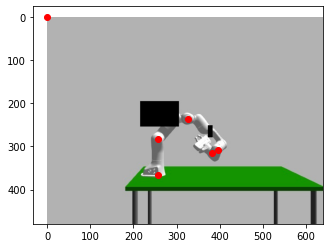

In [114]:
weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_occ_b4_e30_v2.pth'

model = torch.load(weights_path).to(device)


image = Image.open("/home/jc-merlab/Pictures/Data/planar_occluded/002586.rgb.jpg")
print(type(image))

img = F.to_tensor(image).to(device)
img.unsqueeze_(0)
# print(image.shape)
# image = list(image)
# print(type(images))
# images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(img)
    
keypoints = output[0][0]

print(keypoints)
plt.imshow(image)

# Assuming each keypoint is a tensor representing (x, y)
for i, keypoint in enumerate(keypoints):
    print(f'Key point {i}: {keypoint}')
    keypoint = keypoint.cpu().numpy()
    plt.plot(keypoint[0], keypoint[1], 'ro')
plt.show()

# Plotting the image

# plt.imshow(image)

# for keypoint in output[0]:
#     plt.plot(keypoint[0], keypoint[1], 'ro')

# plt.show()